# Comparing Methods for Minimizing Noise for EEG Data

## Background

EEG stands for electroencephalogram, which is one of many methods for measuring activity in the brain. It uses electrodes placed at differing positions along the scalp, and measures the change in voltage along that area. These electrodes are also known as channels. The idea is that if a particular area of the brain is active while performing a specific task, the change in voltage caused by the brain firing should be picked up by the EEG. The major problem with this is that the brain is always firing, so there is always going to be some noise that the EEG records that washes out the signal. Furthermore, depending on the environment the EEG recording takes place, there is also a possibility that the signal is further drowned by the changes in voltage of the surrounding environment. 

The goal of this project is to compare three different methods for minimizing noise, and determine how effective they are. The first method involves applying a low pass and high pass filter to the dataset. The second and third methods involve applying method one and also subtracting (the second method 2) or dividing (the third method) the noise from the dataset in Fourier Space. The dataset that will be used is a kaggle dataset, containing an EEG recording of a person opening and closing their eyes for 117 seconds (https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset). Each entry also contains a column for whether eyes were open (0) or closed (1) during that instance. Given that previous studies suggest that eyes closed leads to lower arousal than eyes opened (https://pubmed.ncbi.nlm.nih.gov/28943465/), the assumption made for this project is that any instance where eyes are closed contain only noise, and instances where eyes are open contain a signal and noise. 

The data will also be using a select few channels from the EEG cap, which are highlighted in the image below (screenshot taken from https://info.tmsi.com/blog/the-10-20-system-for-eeg):
![alt text](Screenshot.png)

## Preprocessing


### Qualities of the Data
(This section is inspired by the "Load Data" and "Data Preprocessing" sections found here https://www.kaggle.com/code/rizqyad/time-series-data-the-danger-of-shuffling, with some modifications)

Let's first import the data into a dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
import seaborn as sns

In [2]:
df = pd.read_csv('EEG_Eye_State_Classification.csv')
df

AF3       F7       F3      FC5       T7       P7       O1       O2  \
0      4329.23  4009.23  4289.23  4148.21  4350.26  4586.15  4096.92  4641.03   
1      4324.62  4004.62  4293.85  4148.72  4342.05  4586.67  4097.44  4638.97   
2      4327.69  4006.67  4295.38  4156.41  4336.92  4583.59  4096.92  4630.26   
3      4328.72  4011.79  4296.41  4155.90  4343.59  4582.56  4097.44  4630.77   
4      4326.15  4011.79  4292.31  4151.28  4347.69  4586.67  4095.90  4627.69   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14975  4281.03  3990.26  4245.64  4116.92  4333.85  4614.36  4074.87  4625.64   
14976  4276.92  3991.79  4245.13  4110.77  4332.82  4615.38  4073.33  4621.54   
14977  4277.44  3990.77  4246.67  4113.85  4333.33  4615.38  4072.82  4623.59   
14978  4284.62  3991.79  4251.28  4122.05  4334.36  4616.41  4080.51  4628.72   
14979  4287.69  3997.44  4260.00  4121.03  4333.33  4616.41  4088.72  4638.46   

            P8       T8      FC6       F4       F8      AF4  eyeDetection  
0      4222.05  4238.46  4211.28  4280.51  4635.90  4393.85             0  
1      4210.77  4226.67  4207.69  4279.49  4632.82  4384.10             0  
2      4207.69  4222.05  4206.67  4282.05  4628.72  4389.23             0  
3      4217.44  4235.38  4210.77  4287.69  4632.31  4396.41             0  
4      4210.77  4244.10  4212.82  4288.21  4632.82  4398.46             0  
...        ...      ...      ...      ...      ...      ...           ...  
14975  4203.08  4221.54  4171.28  4269.23  4593.33  4340.51             1  
14976  4194.36  4217.44  4162.56  4259.49  4590.26  4333.33             1  
14977  4193.33  4212.82  4160.51  4257.95  4591.79  4339.49             1  
14978  4200.00  4220.00  4165.64  4267.18  4596.41  4350.77             1  
14979  4212.31  4226.67  4167.69  4274.36  4597.95  4350.77             1  

[14980 rows x 15 columns]

There appears to be 14 channels recorded, with 14,980 time measurements. Given that the creator of the dataset states the recordings were taken during a 117 second time frame, the sampling rate, $\Delta t$, can be approximated at about 0.008s $(\frac{117 \space seconds}{14,980 \space measurements})$.

Now, let's look at some summary statistics and whether there are any null values.

In [3]:
df.describe()

AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523   
min      2768.210000    2086.150000   4567.180000    1357.950000   
25%      4611.790000    4057.950000   4604.620000    4190.770000   
50%      4617.950000    4070.260000   4613.330000    4199.490000   
75%      4626.670000    4083.590000   4624.100000    4209.230000   
max    362564.000000  567179.000000   7264.100000  265641.000000   

                 T8           FC6            F4             F8            AF4  \
count  14980.000000  14980.000000  14980.000000   14980.000000   14980.000000   
mean    4231.316200   4202.456900   4279.232774    4615.205336    4416.435832   
std       38.050903     37.785981     41.544312    1208.369958    5891.285043   
min     1816.410000   3273.330000   2257.950000      86.666700    1366.150000   
25%     4220.510000   4190.260000   4267.690000    4590.770000    4342.050000   
50%     4229.230000   4200.510000   4276.920000    4603.080000    4354.870000   
75%     4239.490000   4211.280000   4287.180000    4617.440000    4372.820000   
max     6674.360000   6823.080000   7002.560000  152308.000000  715897.000000   

       eyeDetection  
count  14980.000000  
mean       0.448798  
std        0.497388  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


It appears that there are no null values, but there are very large outliers in the dataset. While the middle 50% of the data appears to be $\mathcal{O}(4000\mu V)$ for each column, the standard deviation appears to be between and $1000\mu V$ and $6000\mu V$. Furthermore, the maxima of some columns are 100 orders of magnitude higher than the mean. This is further illustrated in the plots below, where each plot is the voltage vs time graph for a particular channel.

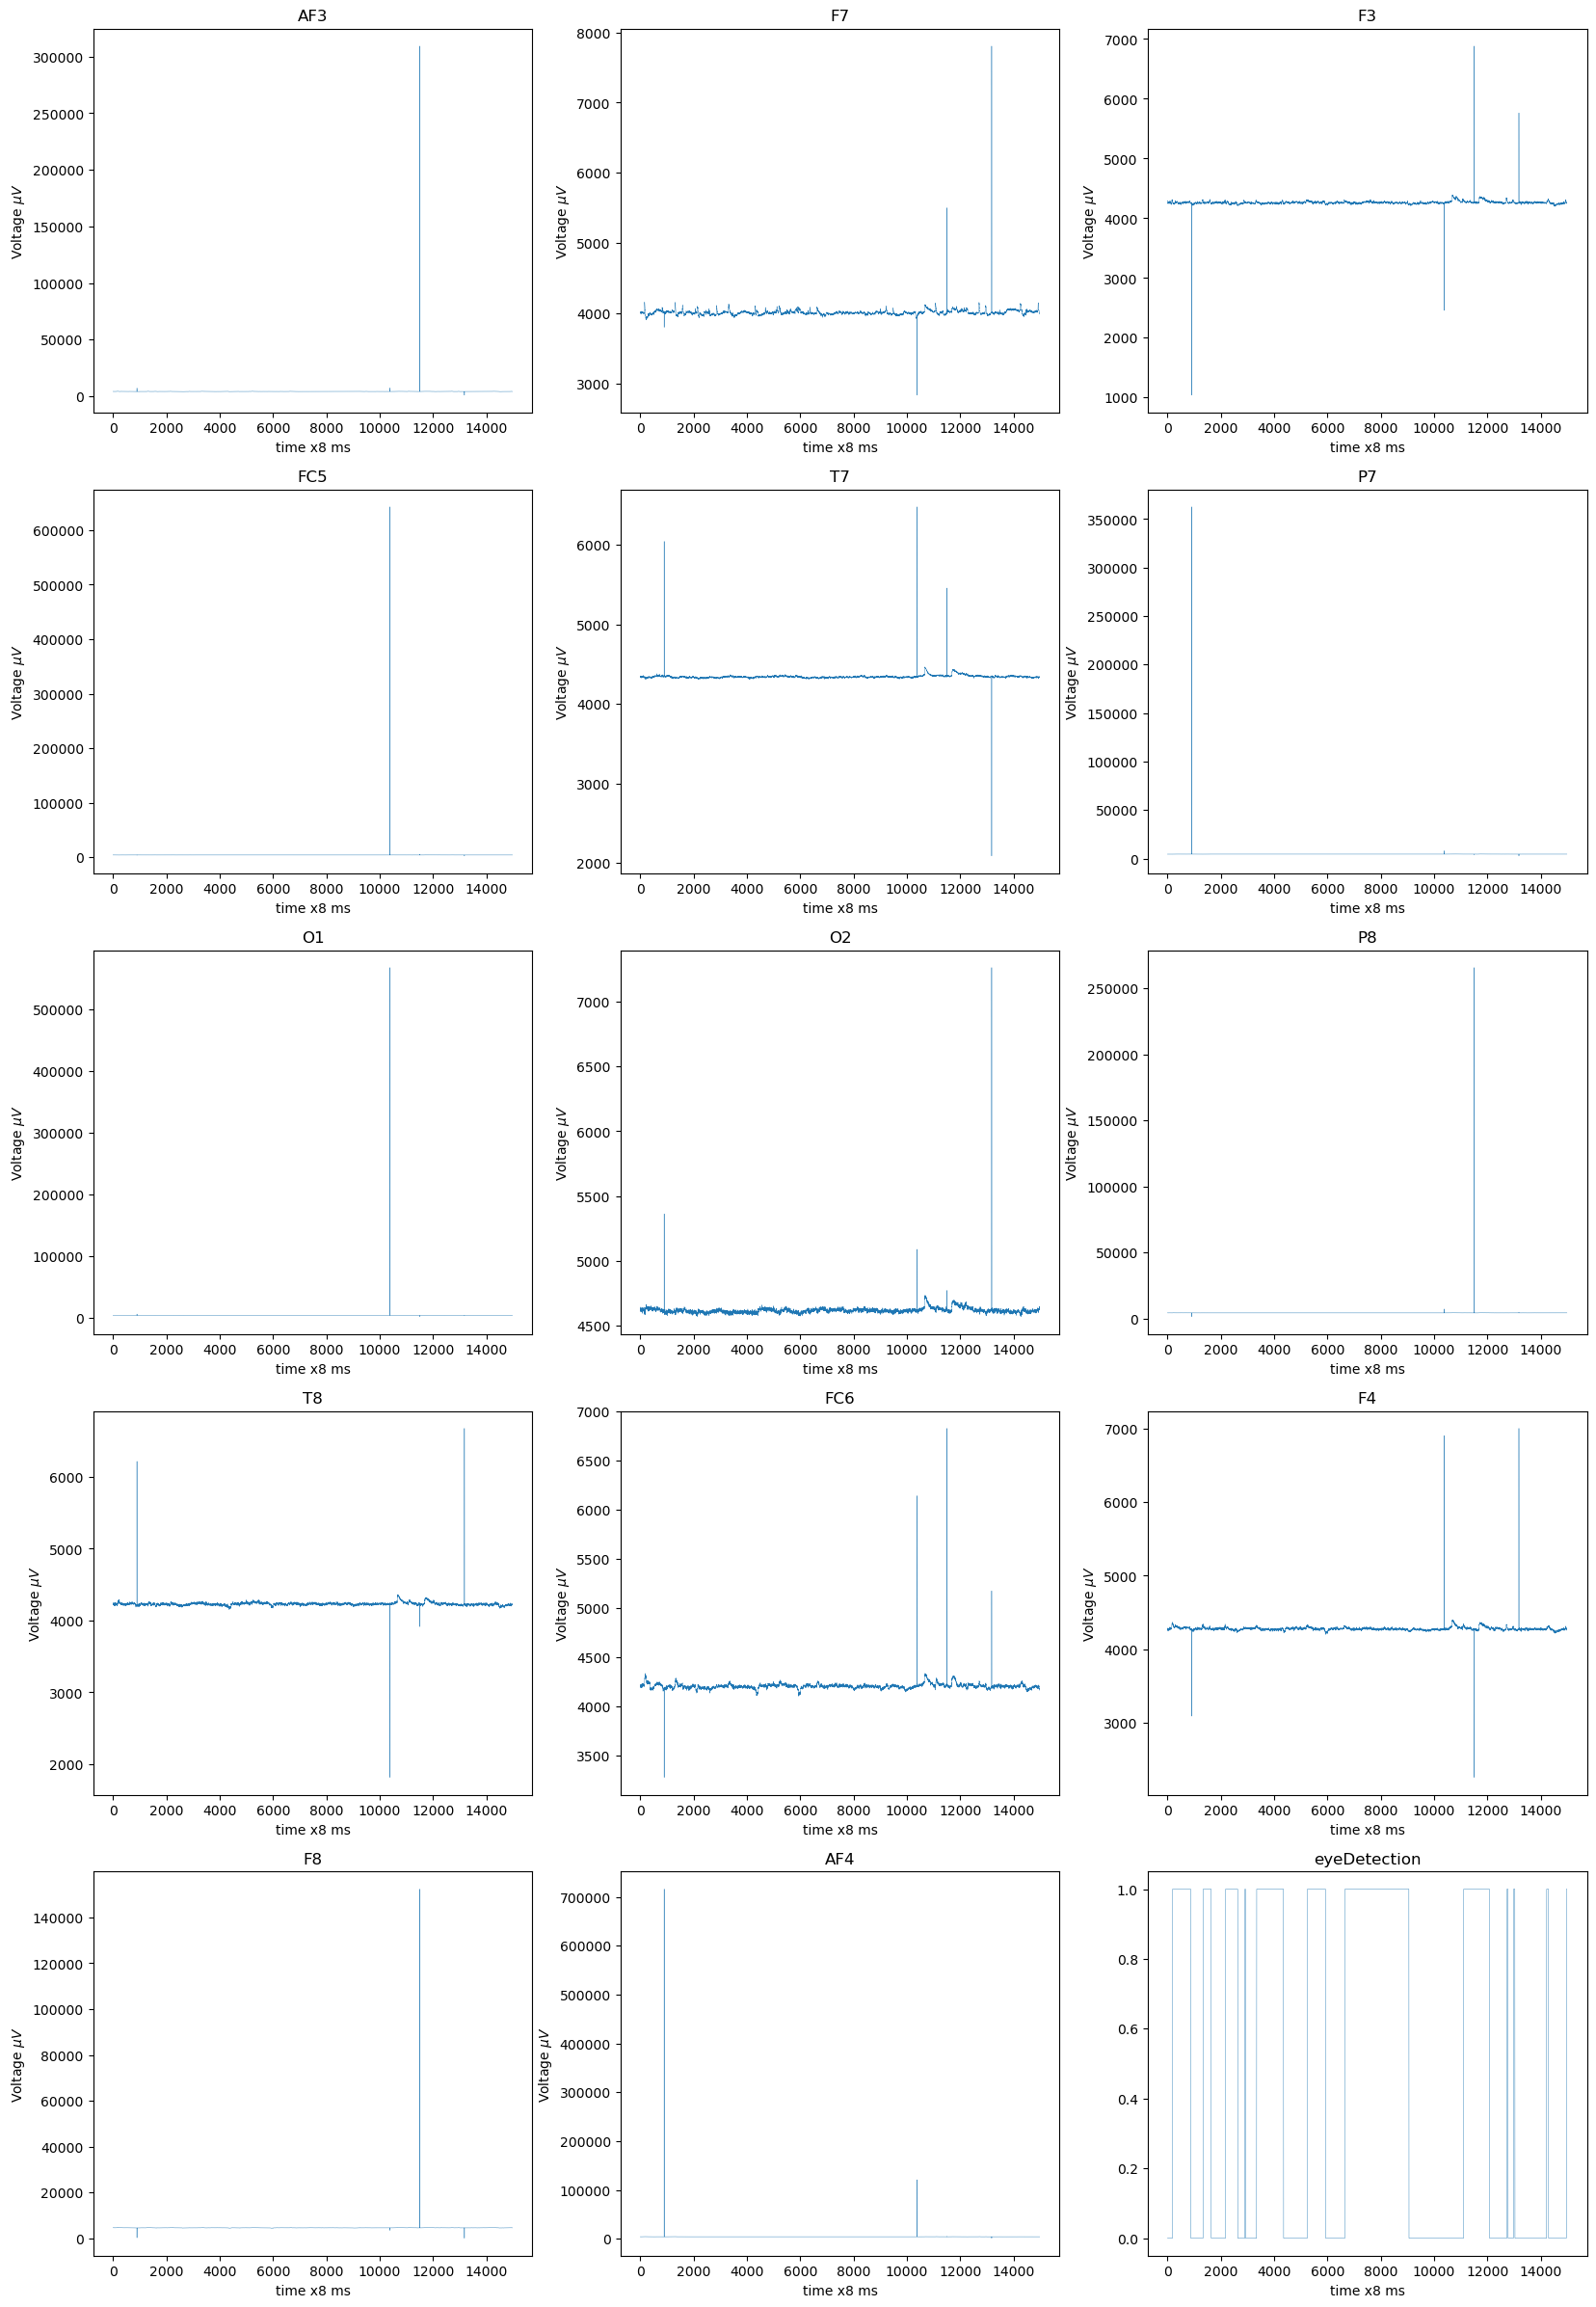

In [5]:
def plot_all_channels():
    fig, ax = plt.subplots(5, 3, figsize=(20,30))
    for i in range(0, len(df.columns)):
        y = 'Voltage $\mu V$'
        x = 'time x8 ms'
        if df.columns[i] == 'eyeDetection':
            y = ''
        channel = df.columns[i]
        df[channel].plot(title=channel, ax=ax.reshape(-1)[i], 
                         xlabel=x, ylabel=y, linewidth=0.3)
    plt.show()
plot_all_channels()

### Outliers
Since it is extremely unlikely that the brain produced voltage readings on the order of magnitude of these outliers, it is more likely due to some error from the equipment and should be removed so as to not interfere with future analysis. In order to remove outliers, a function will be created that will:
1. Calculate the standard deviation from a trimmed version of each column (since including the outliers in the calculation produces a very high standard deviation)
1. Set any values that are more than 25 standard deviations away from the mean to null (this number was chosen through trial and error)

In [6]:
def remove_outliers(col):
    # using std of col w/ 5% trim
    low_5 = int(.05*len(col))
    high_5 = int(.95*len(col))
    trim_col = col.sort_values()[low_5:high_5]
    sigma = trim_col.std()
    mu = col.mean()
    
    # assign values 25 sigma away from mean as null
    for i in range(len(col)):
        entry = np.abs(col[i] - mu)
        if entry > 25*sigma:
            col[i] = np.NaN
    return col

df = df.apply(remove_outliers)
df.describe()

AF3            F7            F3           FC5            T7  \
count  14976.000000  14977.000000  14976.000000  14976.000000  14976.000000   
mean    4301.378607   4009.493500   4264.083569   4122.377696   4341.561287   
std       37.770271     30.135974     21.335365     20.929477     17.007343   
min     4197.950000   3797.950000   4197.440000   4058.460000   4304.620000   
25%     4280.510000   3990.770000   4250.260000   4108.210000   4331.790000   
50%     4294.360000   4005.640000   4262.560000   4120.510000   4338.970000   
75%     4311.790000   4023.080000   4270.770000   4132.310000   4347.180000   
max     4504.100000   4156.920000   4386.150000   4250.260000   4463.590000   

                 P7            O1            O2            P8            T8  \
count  14976.000000  14976.000000  14977.000000  14976.000000  14976.000000   
mean    4620.060675   4072.823013   4615.798831   4201.341742   4231.202968   
std       18.517252     20.910175     18.384103     17.841047     19.765889   
min     4566.150000   4026.150000   4567.180000   4147.690000   4152.820000   
25%     4611.790000   4057.950000   4604.620000   4190.770000   4220.510000   
50%     4617.950000   4070.260000   4613.330000   4199.490000   4229.230000   
75%     4626.670000   4083.590000   4624.100000   4209.230000   4239.490000   
max     4756.920000   4178.460000   4770.260000   4320.000000   4362.560000   

                FC6            F4            F8           AF4  eyeDetection  
count  14976.000000  14976.000000  14976.000000  14976.000000  14980.000000  
mean    4202.150055   4279.089914   4606.009665   4361.304558      0.448798  
std       24.475270     20.093956     33.405176     38.472996      0.497388  
min     4100.000000   4201.030000   4443.080000   4205.640000      0.000000  
25%     4190.260000   4267.690000   4590.770000   4342.050000      0.000000  
50%     4200.510000   4276.920000   4603.080000   4354.870000      0.000000  
75%     4211.280000   4287.180000   4617.440000   4372.820000      1.000000  
max     4332.310000   4397.950000   4833.850000   4573.330000      1.000000

After applying the function to the dataset, the data appears to produce a more realistic summary of the data for each channel. Below is a plot of each channel after outliers were removed.

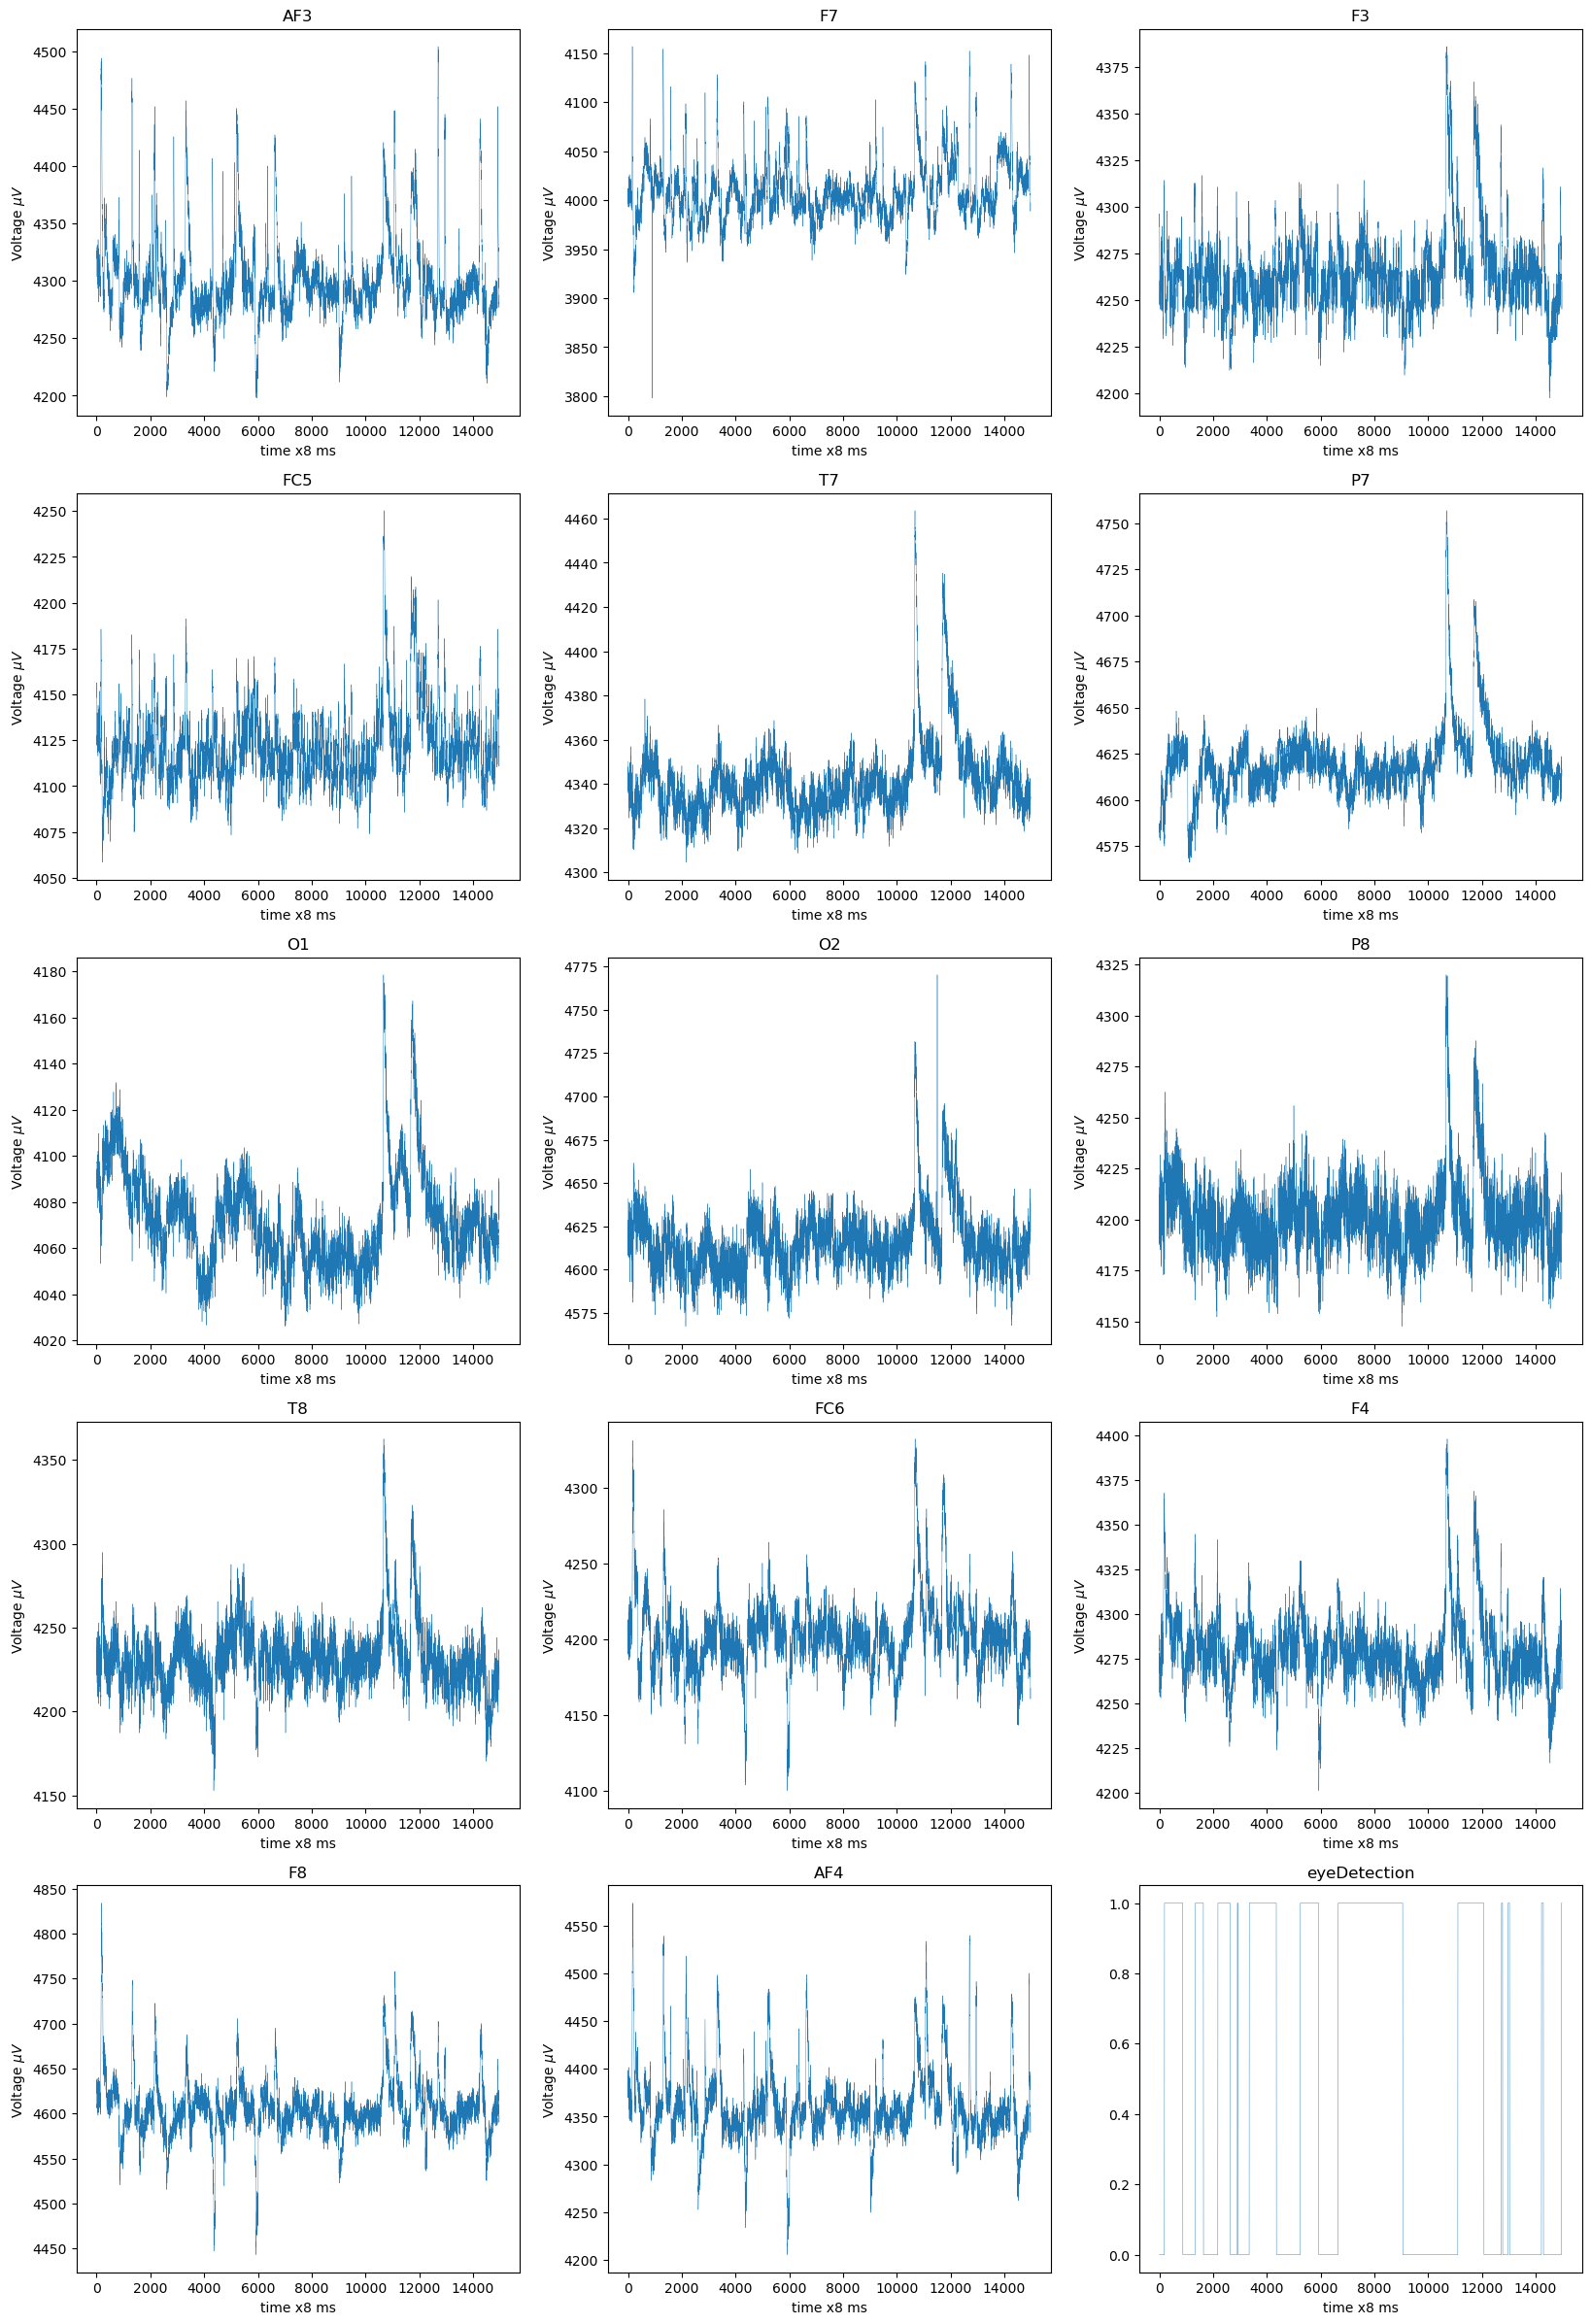

In [7]:
plot_all_channels()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14976 non-null  float64
 1   F7            14977 non-null  float64
 2   F3            14976 non-null  float64
 3   FC5           14976 non-null  float64
 4   T7            14976 non-null  float64
 5   P7            14976 non-null  float64
 6   O1            14976 non-null  float64
 7   O2            14977 non-null  float64
 8   P8            14976 non-null  float64
 9   T8            14976 non-null  float64
 10  FC6           14976 non-null  float64
 11  F4            14976 non-null  float64
 12  F8            14976 non-null  float64
 13  AF4           14976 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


The only problem is that each column now has some null values from erasing the outliers. Setting the outliers to 0 causes weird spikes in the data after performing operations in the frequency domain, so there will be extra caution to drop null values when working with specific columns. The final form of preprocessing involves removing frequencies outside a specific range (0.5 Hz to 30 Hz), since this is where most brain activity lies (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6479797/#:~:text=The%20Alpha%20band%20(8%E2%80%9312,with%20brain%20diseases%20%5B2%5D.). This will be done in the next section, as it involves using the discrete fourier transform to display the data in the frequency domain.

## Method 1: Applying a Filter to the EEG Data to Only Display the Alpha and Beta Frequencies.

### Functions
The previous link also mentions that frequencies recorded in the Alpha range (8-12 Hz) and the Beta range (12-30 Hz) are typical frequencies for someone who is awake. Therefore, the first method for minimizing noise is to filter the data to only keep values that are within this frequency range. To do this, three functions will be constructed:
1. do_fft, which applies the fft to an inputed column, also ensuring that it is shifted properly and drops any null values
1. do_ifft, which is similar to the previous function but for converting back to the time domain
1. freq_filter, which will convert a given column to the frequency domain, and set any values outside the given bounds to 0 (e.g. since the values for this method are 8 and 30, any frequencies outside -30 to -8 and 8 to 30 will be set to 0). It will then convert back to the time domain, and override the column with the new outputs, making sure to skip any null values from the original column.

In [9]:
# function to make it easier to convert columns to 
# the frequency domain
def do_fft(col):
    # N and sampling rate
    N = len(col.dropna())
    d = 0.008
    
    # the range of frequencies, shifted to
    # where 0 Hz is at the center,
    # with the amplitude at that frequency (Hz)
    frange = fftshift(fftfreq(N, d))
    colFT = fftshift(fft(col.dropna()))
    
    return frange, colFT

# function to make converting back to the time 
# domain easier
def do_ifft(col):
    return np.abs(ifftshift(ifft(col)))

# function to filter different frequencies from a 
# given column
def freq_filter(col, low, high):
    # convert to frequency domain
    colfft = do_fft(col)
    col_to_inv = colfft[1]
    # set 0 any frequency beyond the range [low, high] and [-high, low]
    to_filter = np.array([1 if low < np.abs(i) < high else 0 for i in colfft[0]])
    col_to_inv *= to_filter
    # convert back to time domain
    col_filtered = do_ifft(col_to_inv)
    
    return pd.Series(col_filtered)

### Finish Preprocessing
Let's finish preprocessing the data, by filtering out all frequencies that are not within 0.5 Hz and 30 Hz. This is so the only significant frequencies from the data is only from the brain, and not the surrounding environment.

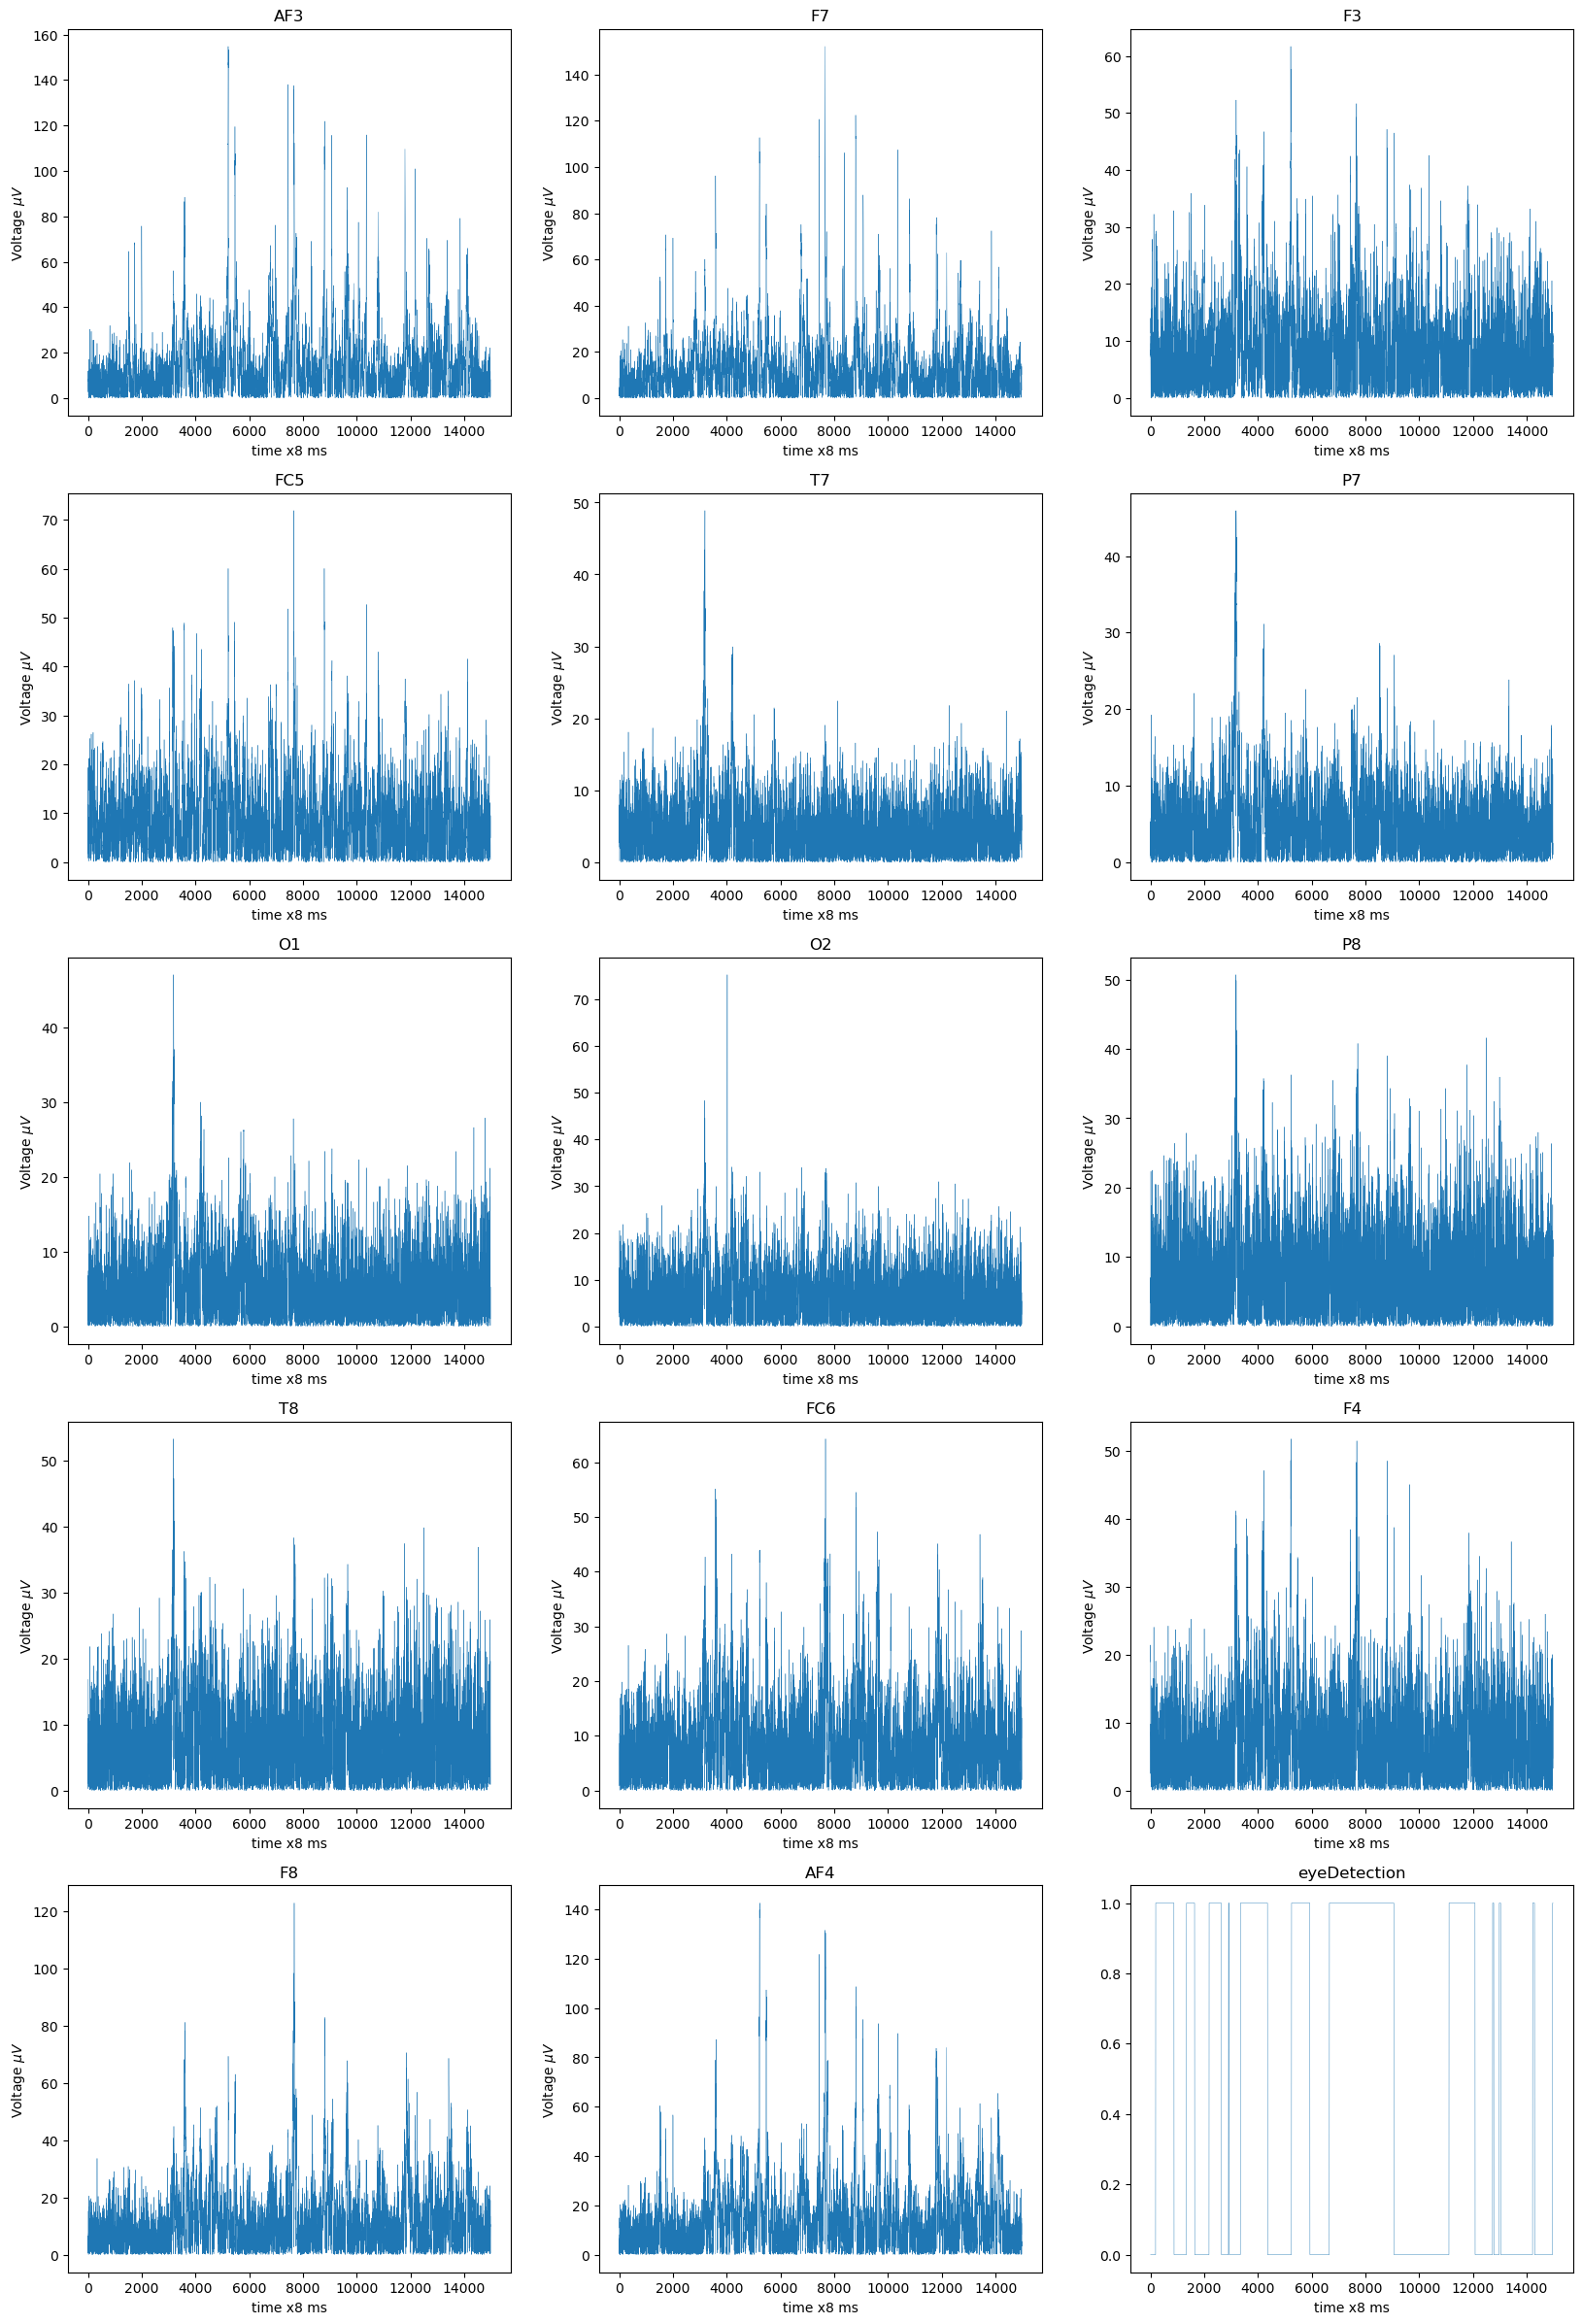

In [10]:
# the "eyes" variable is to ensure that the eyeDetection column 
# is preserved
eyes = df.copy().eyeDetection
df = df.apply(freq_filter, args=(0.5, 30))
df.eyeDetection = eyes
plot_all_channels()

### Applying Alpha Beta Filter
First, let's look at each channel in the frequency domain. From the plots below, it appears to be very symmetric, with a very sharp point at the center. This peak has been cut off, as it is on the oder of 1e6, which makes the surroudning frequencies harder to see.

C:\Users\eviek\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


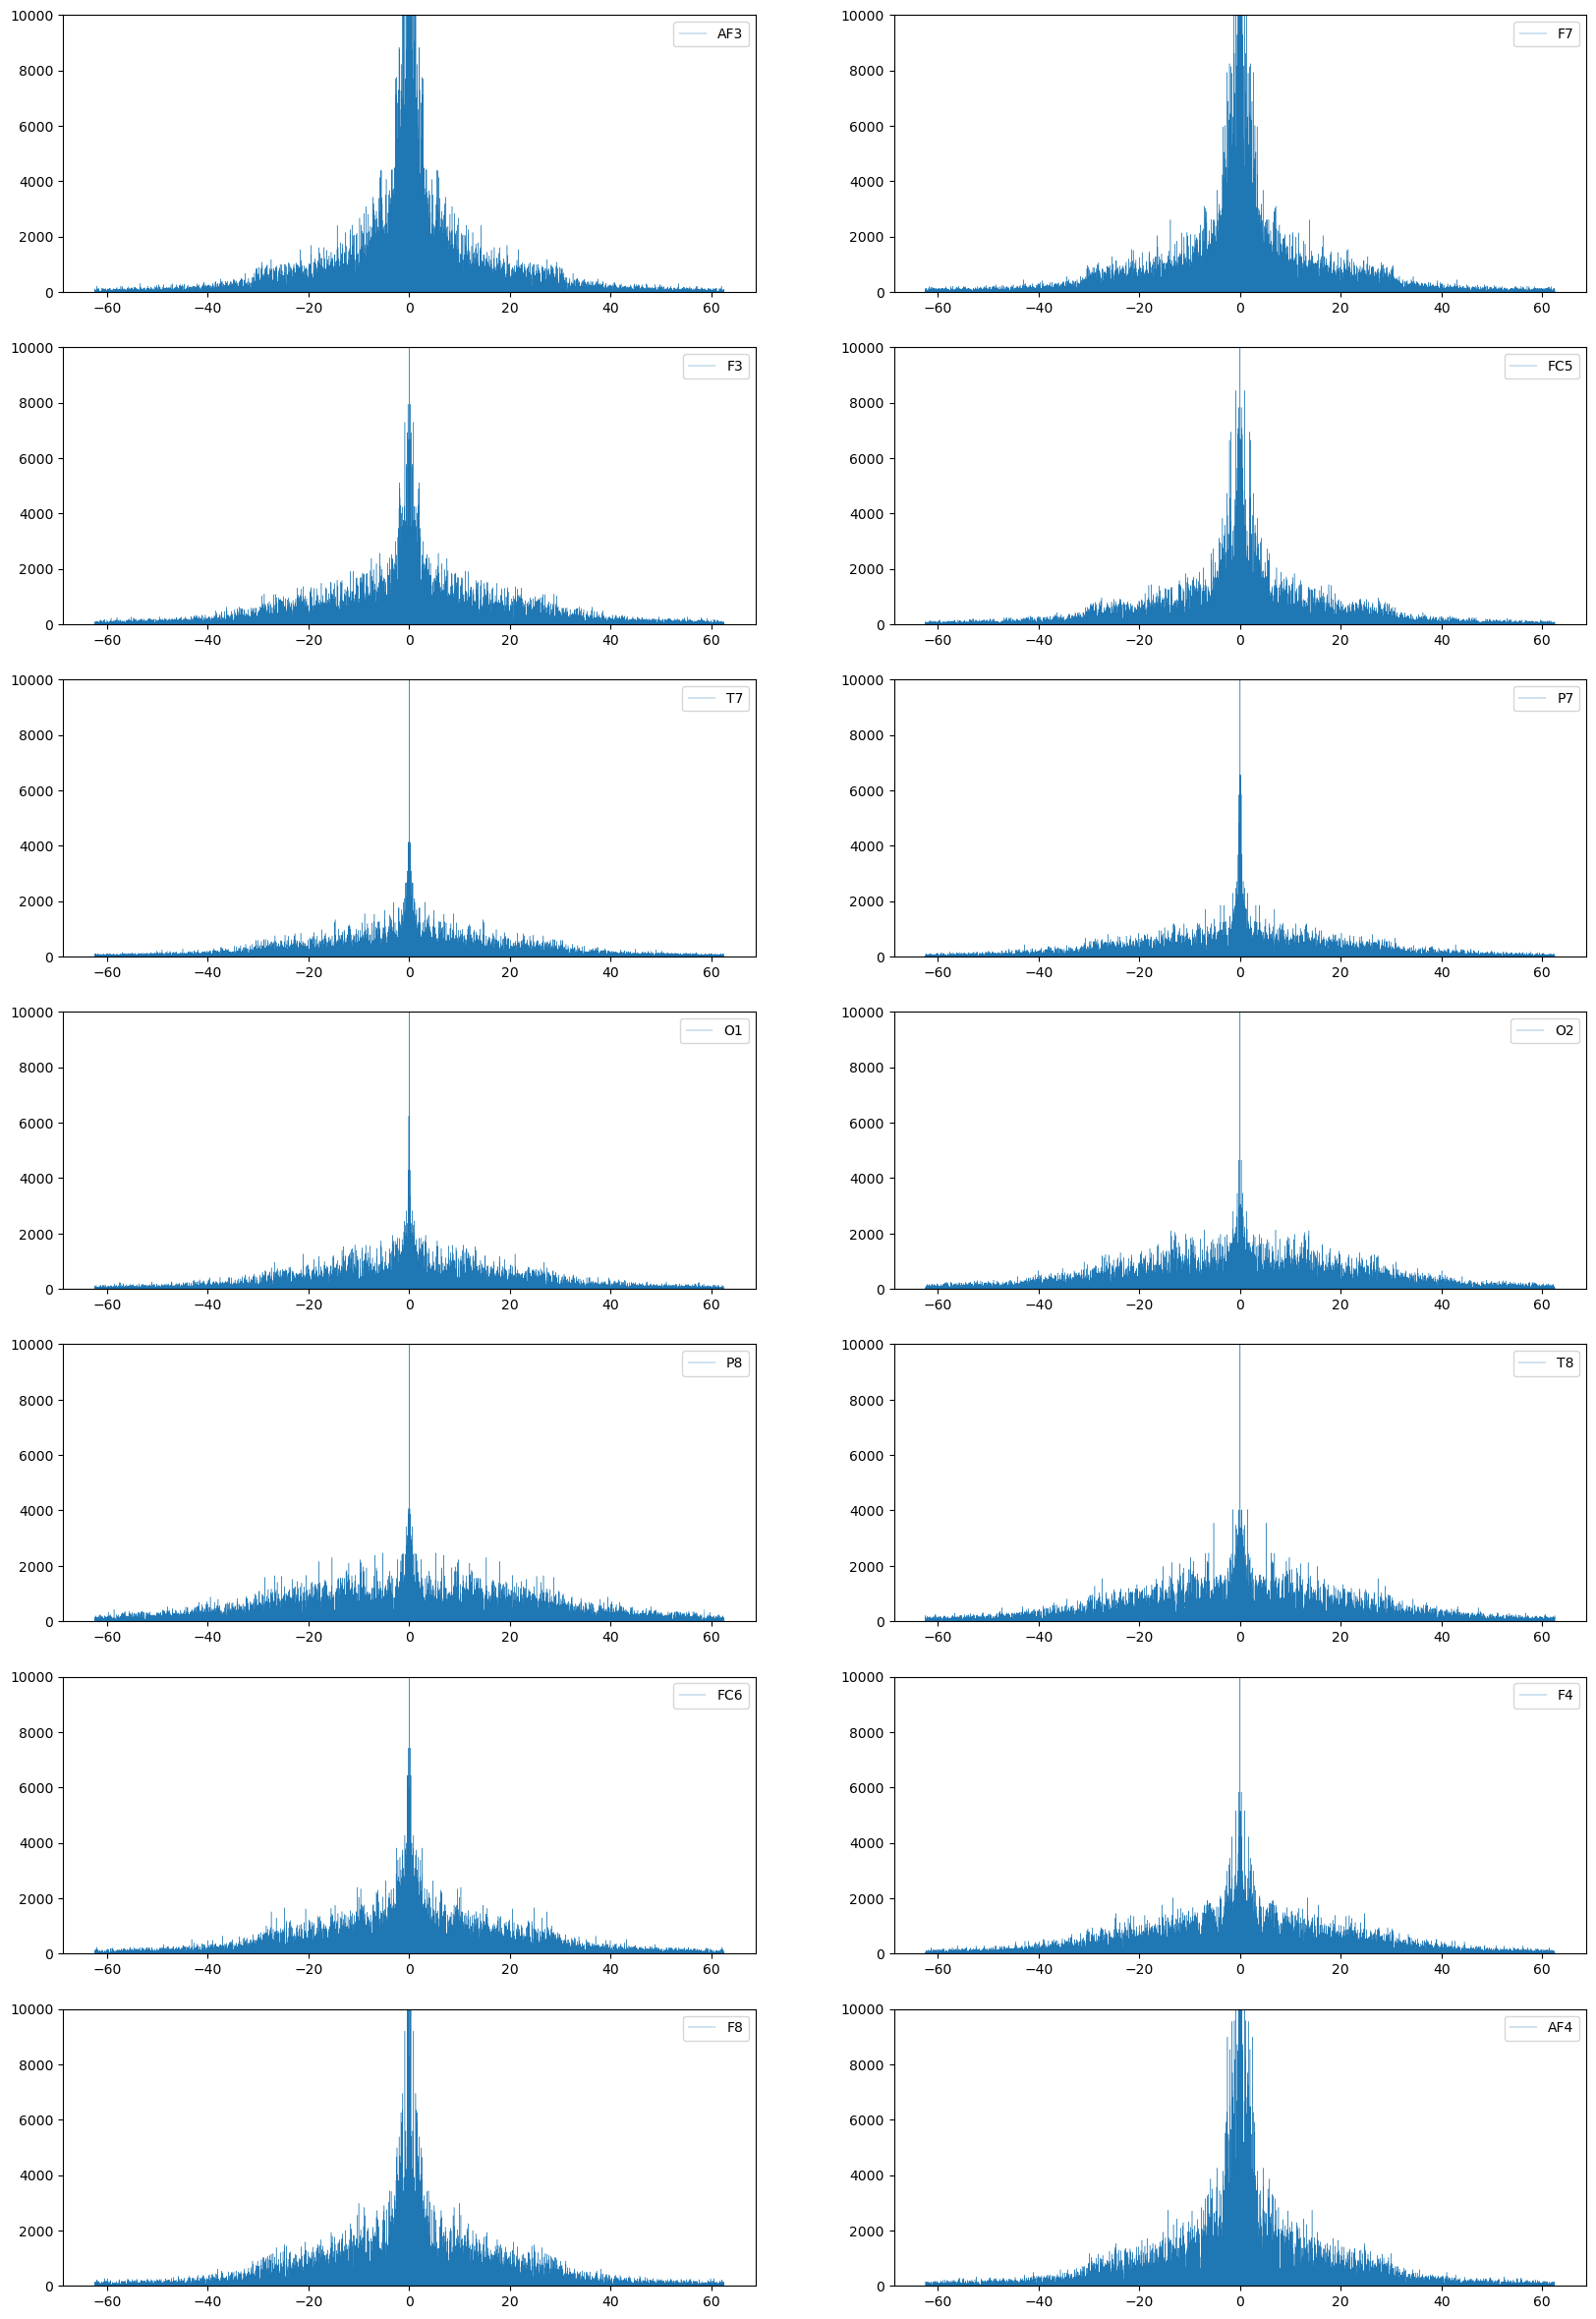

In [11]:
fig, axs = plt.subplots(7,2, figsize=(20,30))
axs = axs.reshape(-1)
for i in range(len(df.columns)-1):
    col = df.columns[i]
    colfft = do_fft(df[col])
    axs[i].plot(colfft[0], colfft[1], label=col, 
                linewidth=0.3)
    axs[i].set_ylim(0,1e4)
    axs[i].legend()

### Results
Then, a new dataframe will be copied that only contains the alpha and beta frequencies. This will be called abdf, for the latin equvalents of alpha (a), and beta(b). To see if there are any patterns that arise with whether the eyes are open or closed, the eyeDetection column, scaled and shifted for better visualization, will be plotted on top of the filtered channels. 

Unfortunately, this proved to not be a successful method, as there are no patterns that can be seen in any of the channels. More must be done in order to get something meaningful.

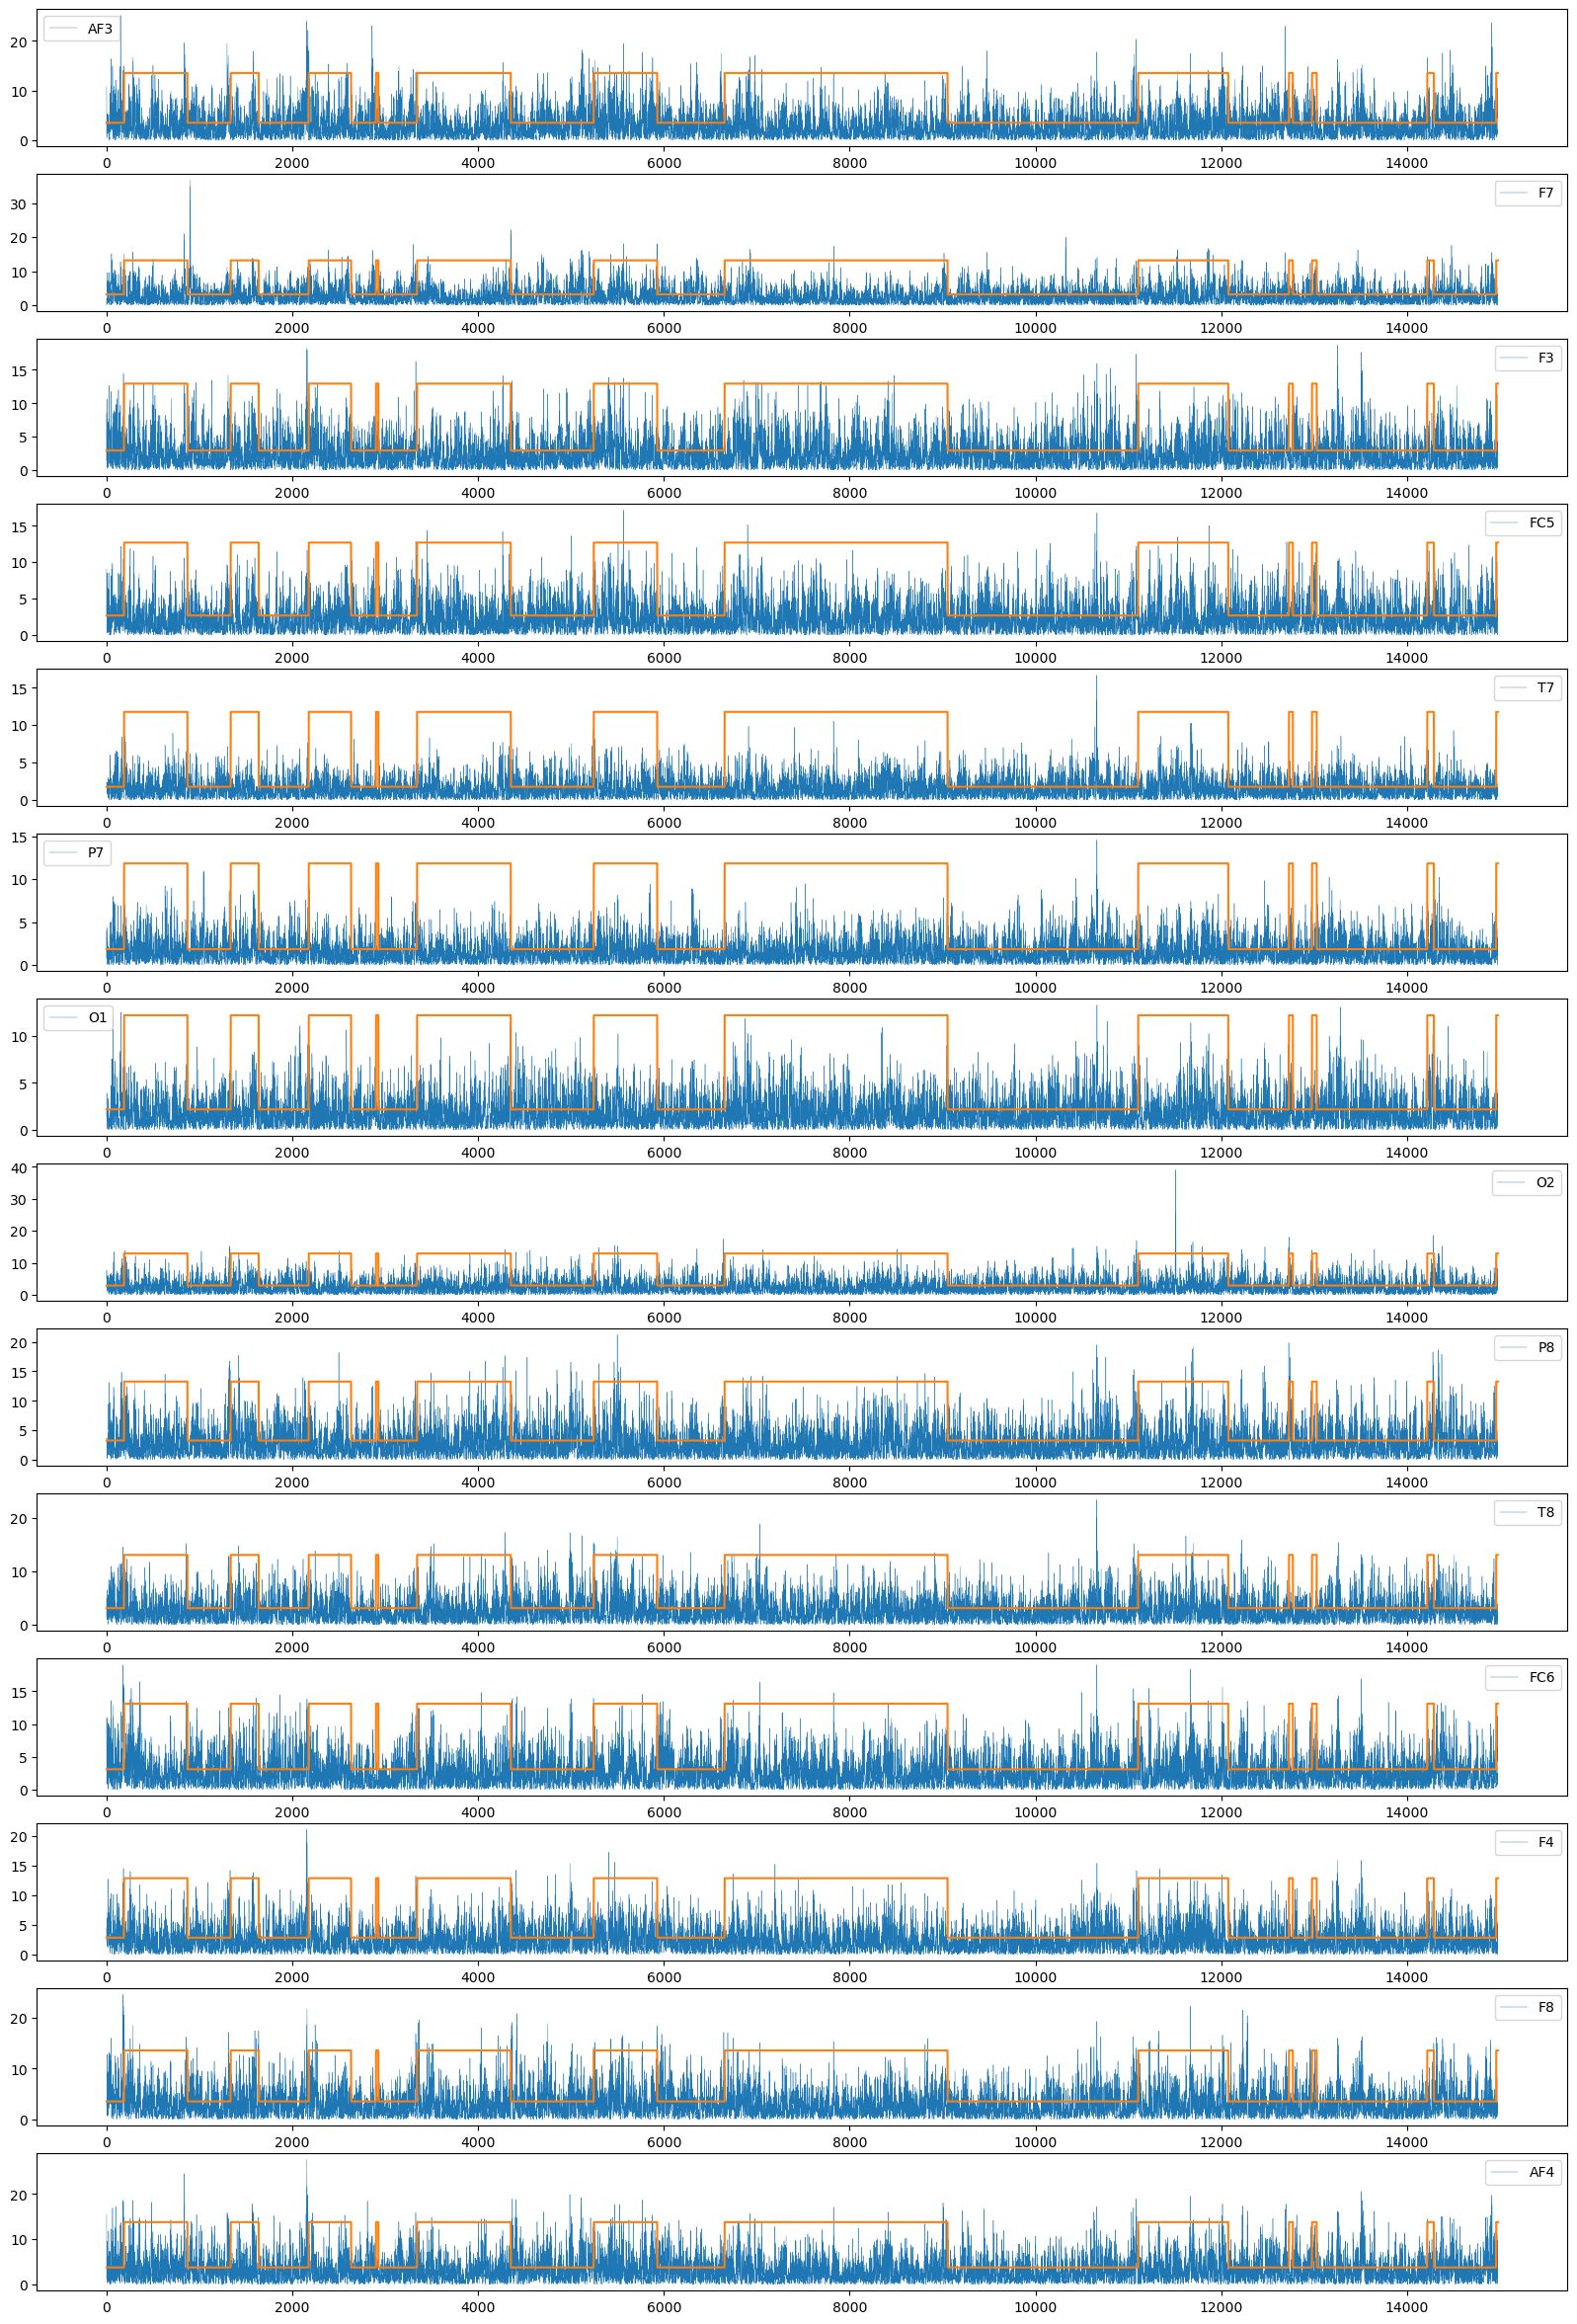

In [12]:
# apply filter
abdf = df.copy()
abdf = abdf.apply(freq_filter, args=(8,30))
abdf = abdf.apply(remove_outliers)
abdf['eyeDetection'] = df.eyeDetection

# plot filtered channel with eyeDetection
fig, axs = plt.subplots(14,1, figsize=(20,30))
axs = axs.reshape(-1)
for i in range(len(abdf.columns)-1):
    col = abdf.columns[i]
    m = abdf[col].mean()
    abdf[col].plot(ax=axs[i], legend=col, linewidth=0.3)
    axs[i].plot(abdf.eyeDetection*10 + m)

## Method 2: Subtracting Noise From Data in Fourier Space
The idea behind this method is very simple:
1. The data comprises of signal and noise (or, $d(t_n) = s(t_n) + \zeta(t_n)$)
1. Therefore, the fourier transform is similar ($\tilde{d}(\omega) = \tilde{s}(\omega) + \tilde{\zeta}(\omega)$)
1. Thus, $\tilde{s}(\omega) = \tilde{d}(\omega) - \tilde{\zeta}(\omega)$, and taking the inverse will give $s(t_n)$

Using our assumption that the eyes being closed give outputs that are only noise, This would mean that all instances where eyes are closed are independent of one another (i.e. $\zeta(t_n)$ is not dependent on $\zeta(t_{n-1})$). If this is true, it should not matter whether we fourier transform each interval where the eyes are closed or the whole subset as one interval, it should still give the frequency domain of the random processes recorded when eyes were closed.

This will be done on two datasets: the alpha beta dataset, and the original dataset that had the 0.5-30 Hz filter applied.

### CAUTION!
A potential downside to this method is that the amplitude of the EEG readings will be REALLY small compared to the original dataset. However, most uses of EEG data care less about the amplitude of the readings, and moreso the frequencies that are outputted.    
### Subtracting Noise Using the Alpha Beta Filtered Dataset
First, let's plot the data and noise for each channel in the frequency domain. It appears that the noise follows a similar distribution to the data, though scaled significantly smaller.

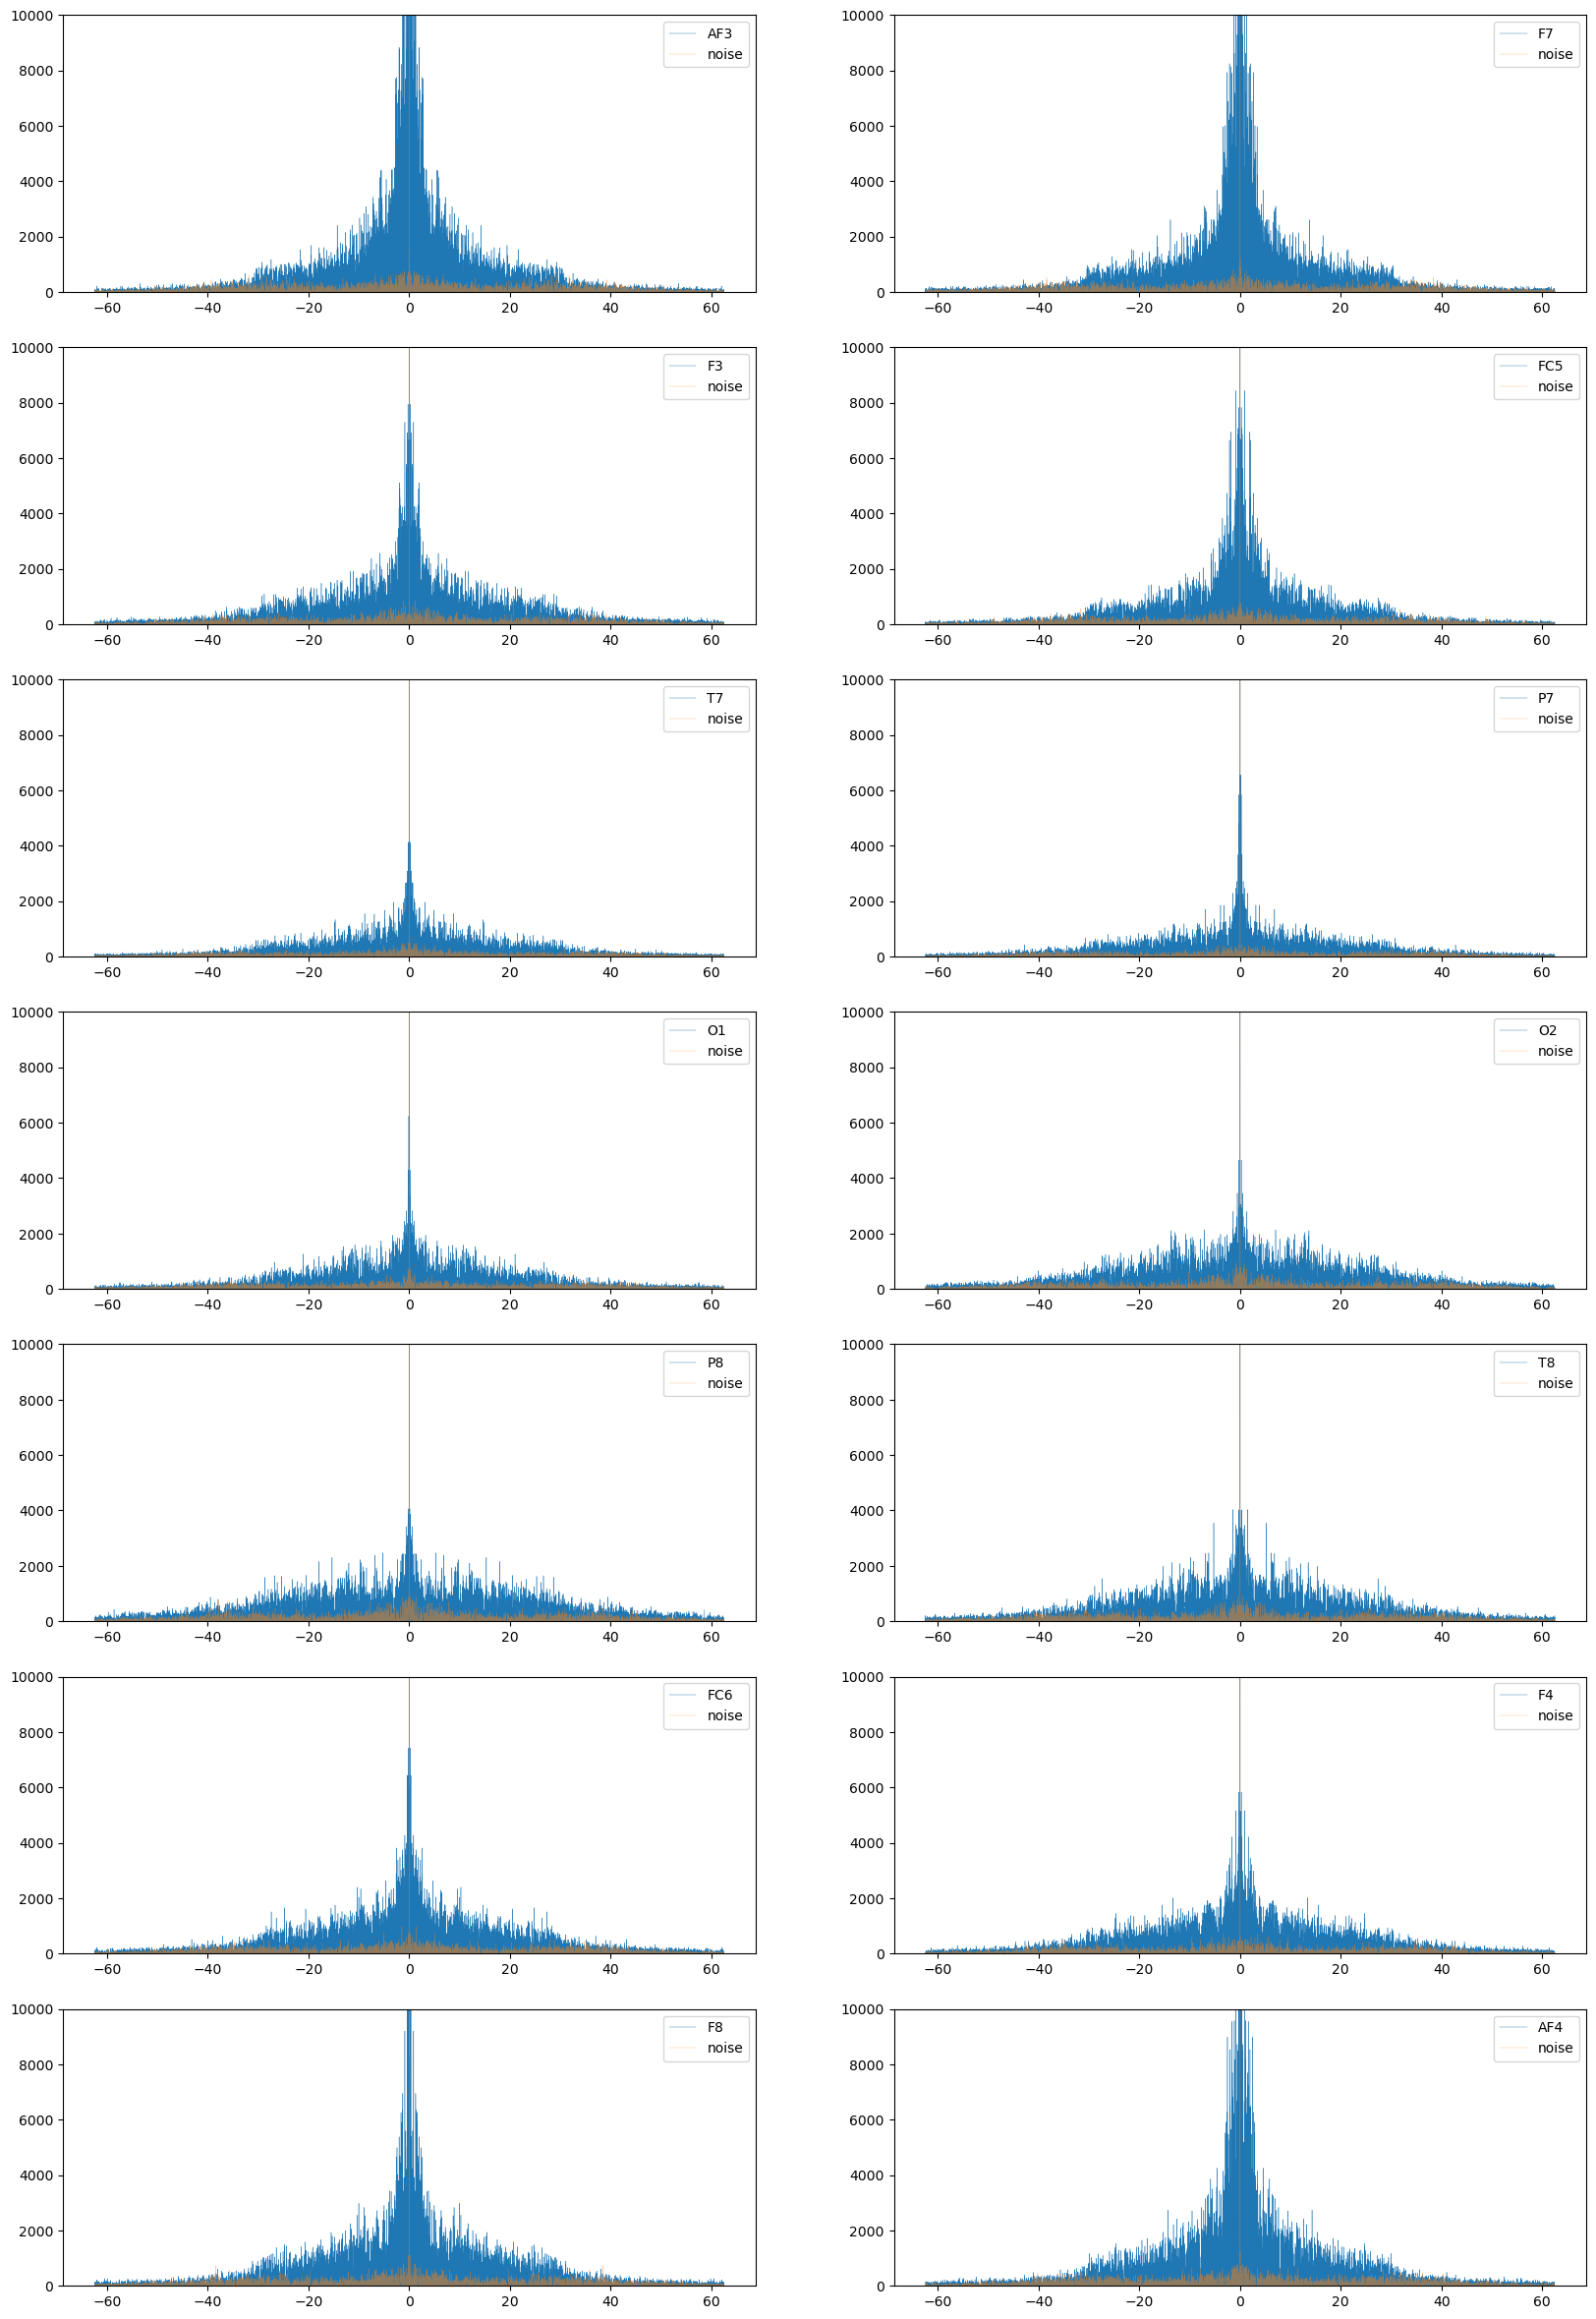

In [13]:
# subset of alpha beta df only containing entries
# where eyes are closed
EC = abdf[df.eyeDetection==1]

fig, axs = plt.subplots(7,2, figsize=(20,30))
axs = axs.reshape(-1)

for i in range(len(EC.columns)-1):
    col = abdf.columns[i]
    datafft = do_fft(df[col])
    noisefft = do_fft(EC[col])
    axs[i].plot(datafft[0], datafft[1], label=col, linewidth=0.3)
    axs[i].plot(noisefft[0], noisefft[1], label='noise', 
                alpha=0.5, linewidth=0.3)
    axs[i].set_ylim(0,1e4)
    axs[i].legend()

### Results
Now, let's subtract the noise from the alpha beta dataset, and use a similar plot for each channel as done in the previous section. This method appears to be successful, as there are some clear patterns emerging within some of the channels. One can notice that for channels AF3, AF4, F7, and F8 (interestingly the channels that are closest to the eye), there appears to be spikes right before the eyes are closed (i.e. when the orange plot makes a step upwards). 

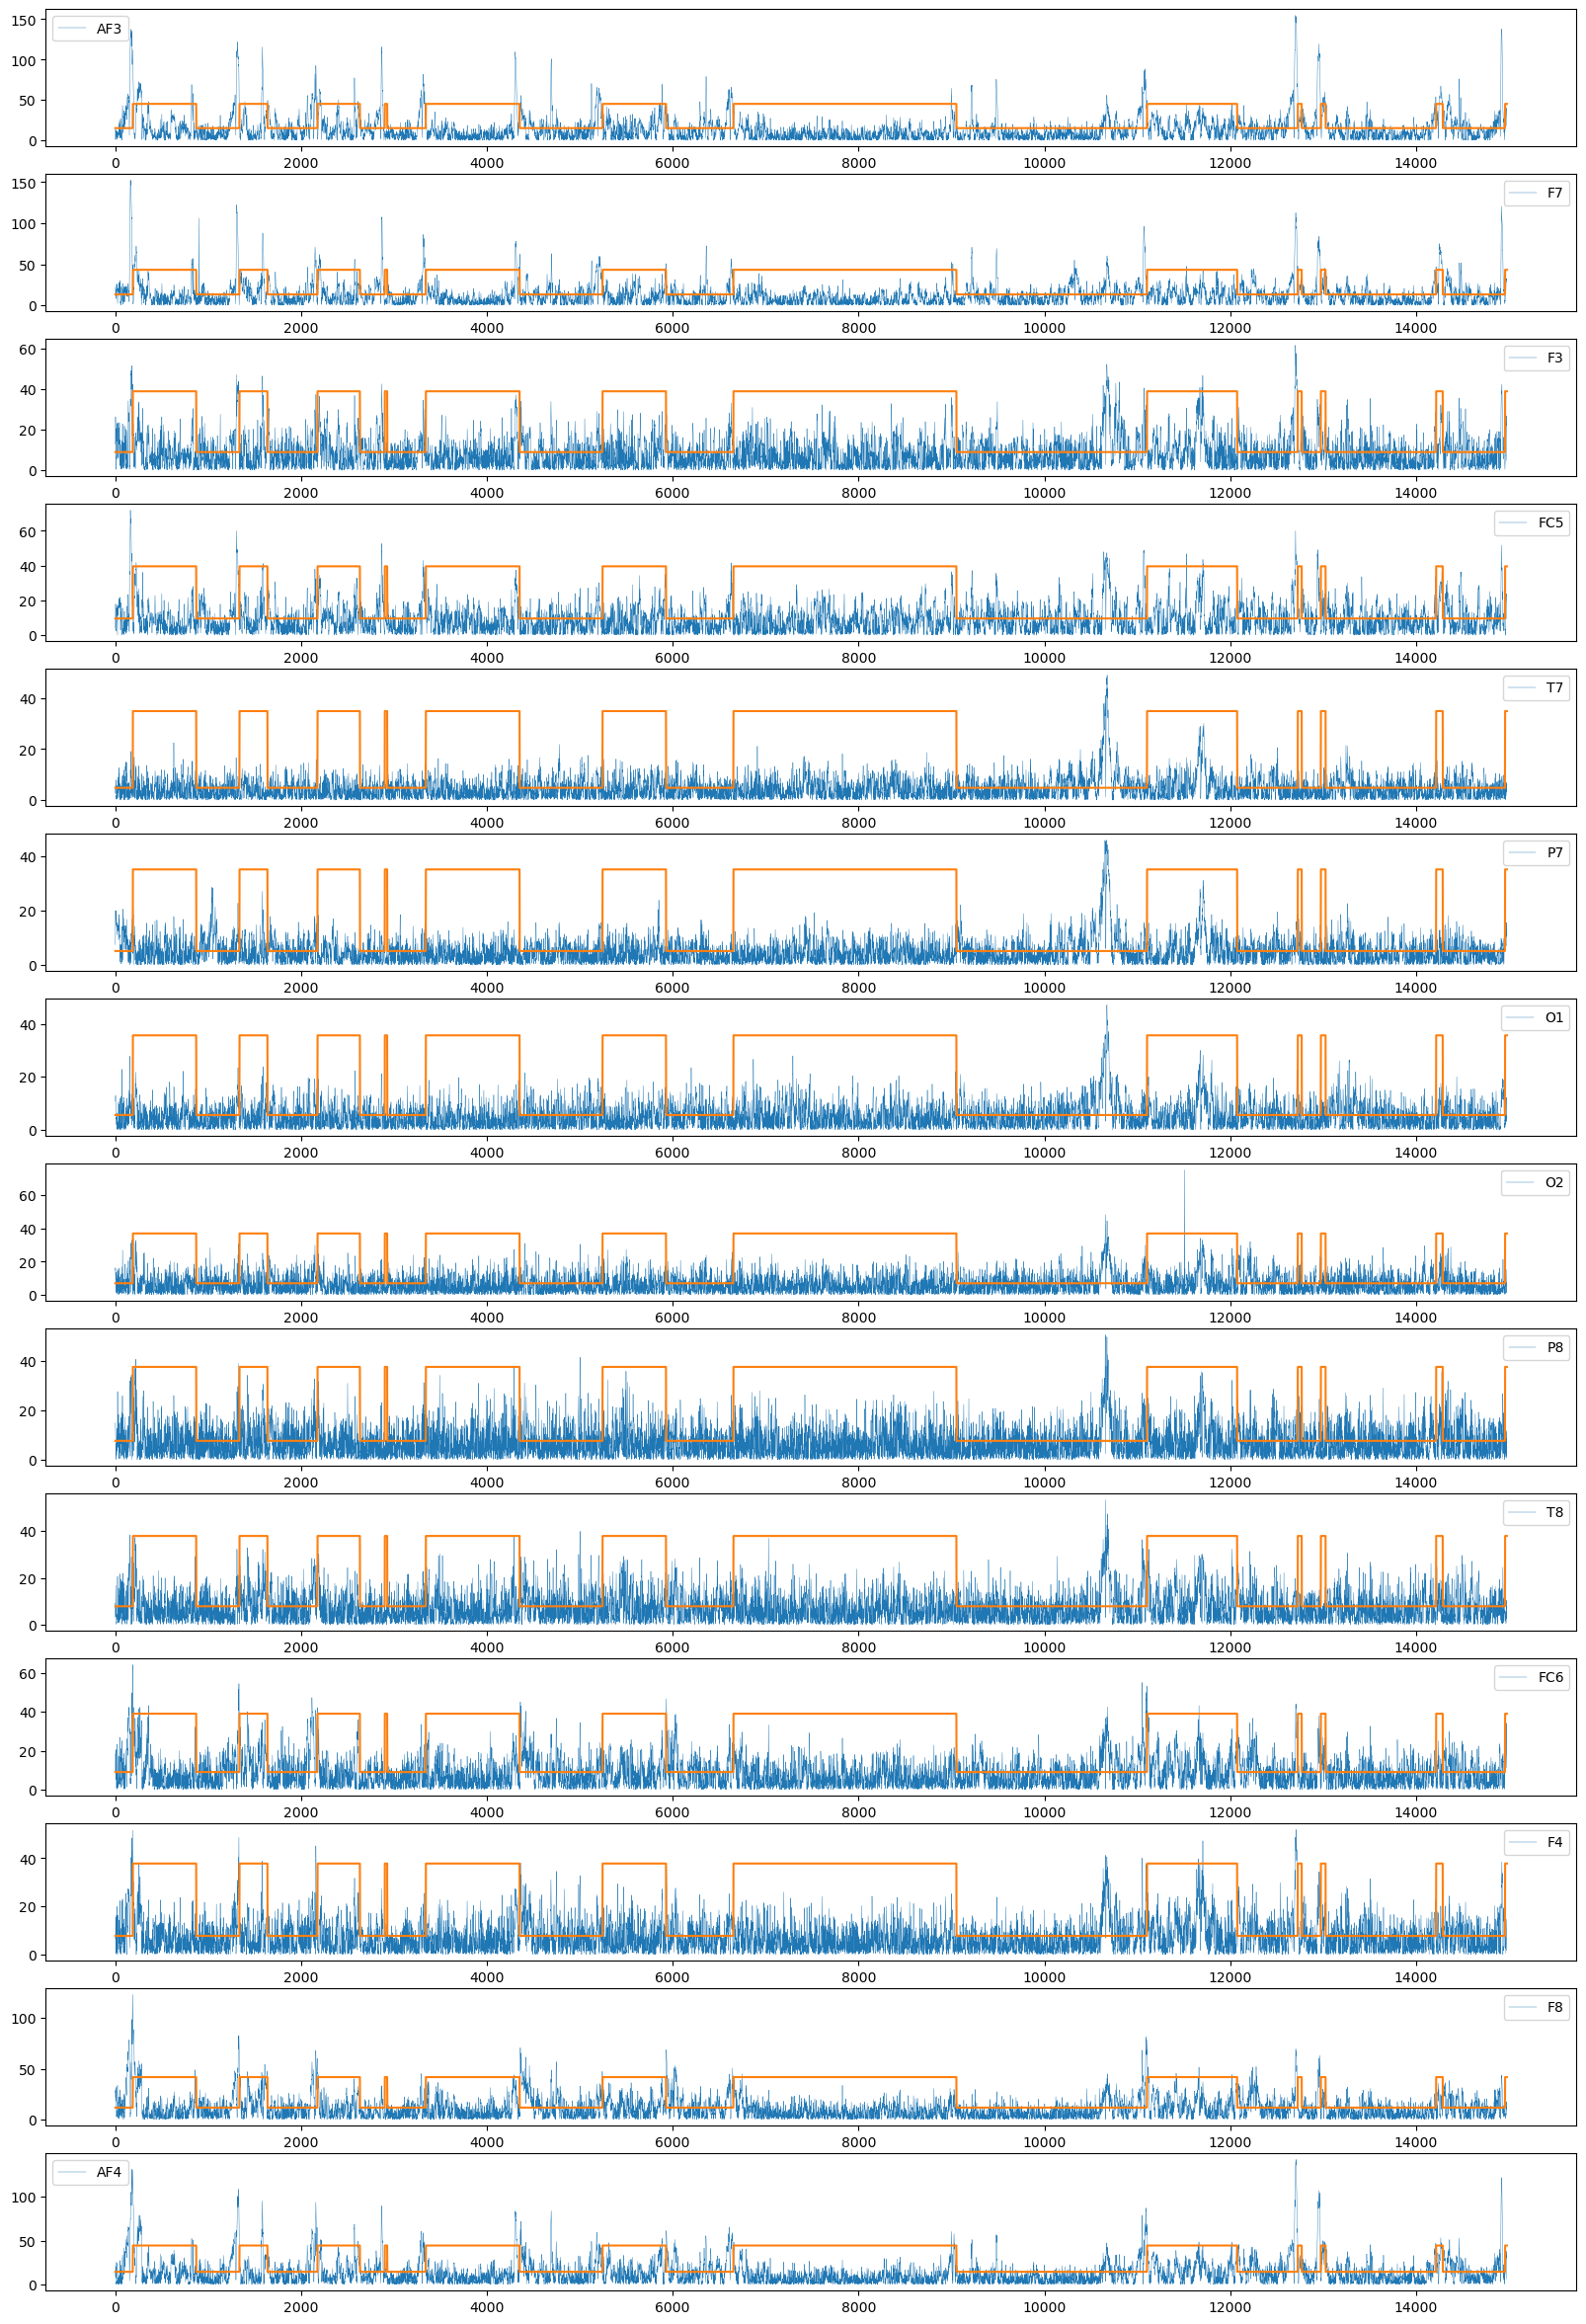

In [14]:
# subset of alpha beta df only containing entries
# where eyes are closed
EC = abdf[df.eyeDetection==1]

fig, axs = plt.subplots(14,1, figsize=(20,30))

# find the signal of each channel and plot 
# with eyes open vs closed
for i in range(len(EC.columns)-1):
    # get data and noise in freq domain
    col = abdf.columns[i]
    datafft = do_fft(df[col])
    noisefft = do_fft(EC[col])
    
    # since data and noise are of different lengths, "fluff"
    # will be added that pads the ends of noisefft with 0s
    fluff_length = (len(datafft[0]) - len(noisefft[0]))/2
    fluff = np.zeros(int(fluff_length))
    noisefft = np.concatenate((fluff, noisefft[1], fluff))
    
    # sometimes the length of nosiefft overshoots, so
    # the else statement skips a few zeros to match the 
    # lengths
    if len(datafft[1]) == len(noisefft):
        signalfft = datafft[1] - noisefft
    else:
        diff = len(noisefft) - len(datafft[1])
        signalfft = datafft[1] - noisefft[diff:]
        
    # convert to time domain
    signal = do_ifft(signalfft)
    
    # plot signal
    axs[i].plot(signal, label=col, linewidth=0.3)
    # scale and shift eyeDetection, then plot it
    m = np.mean(signal)
    axs[i].plot(df.eyeDetection*30 + m)
    axs[i].legend()

### Subtracting Noise Using the Original Filtered Dataset
The same process from before was applied to the original dataset filtered for frequencies between 0.5 Hz and 30 Hz, in order to see if filtering for alpha and beta waves made a significant difference in the output. Comparing the plot below to the plot above, there appears to be very little difference. This not only shows the effectiveness of subtracting the noise in the frequency domain, it also shows the ineffectiveness the previous method of filtering for alpha and beta waves, as otherwise it would produce a significant difference between the above and below figures.

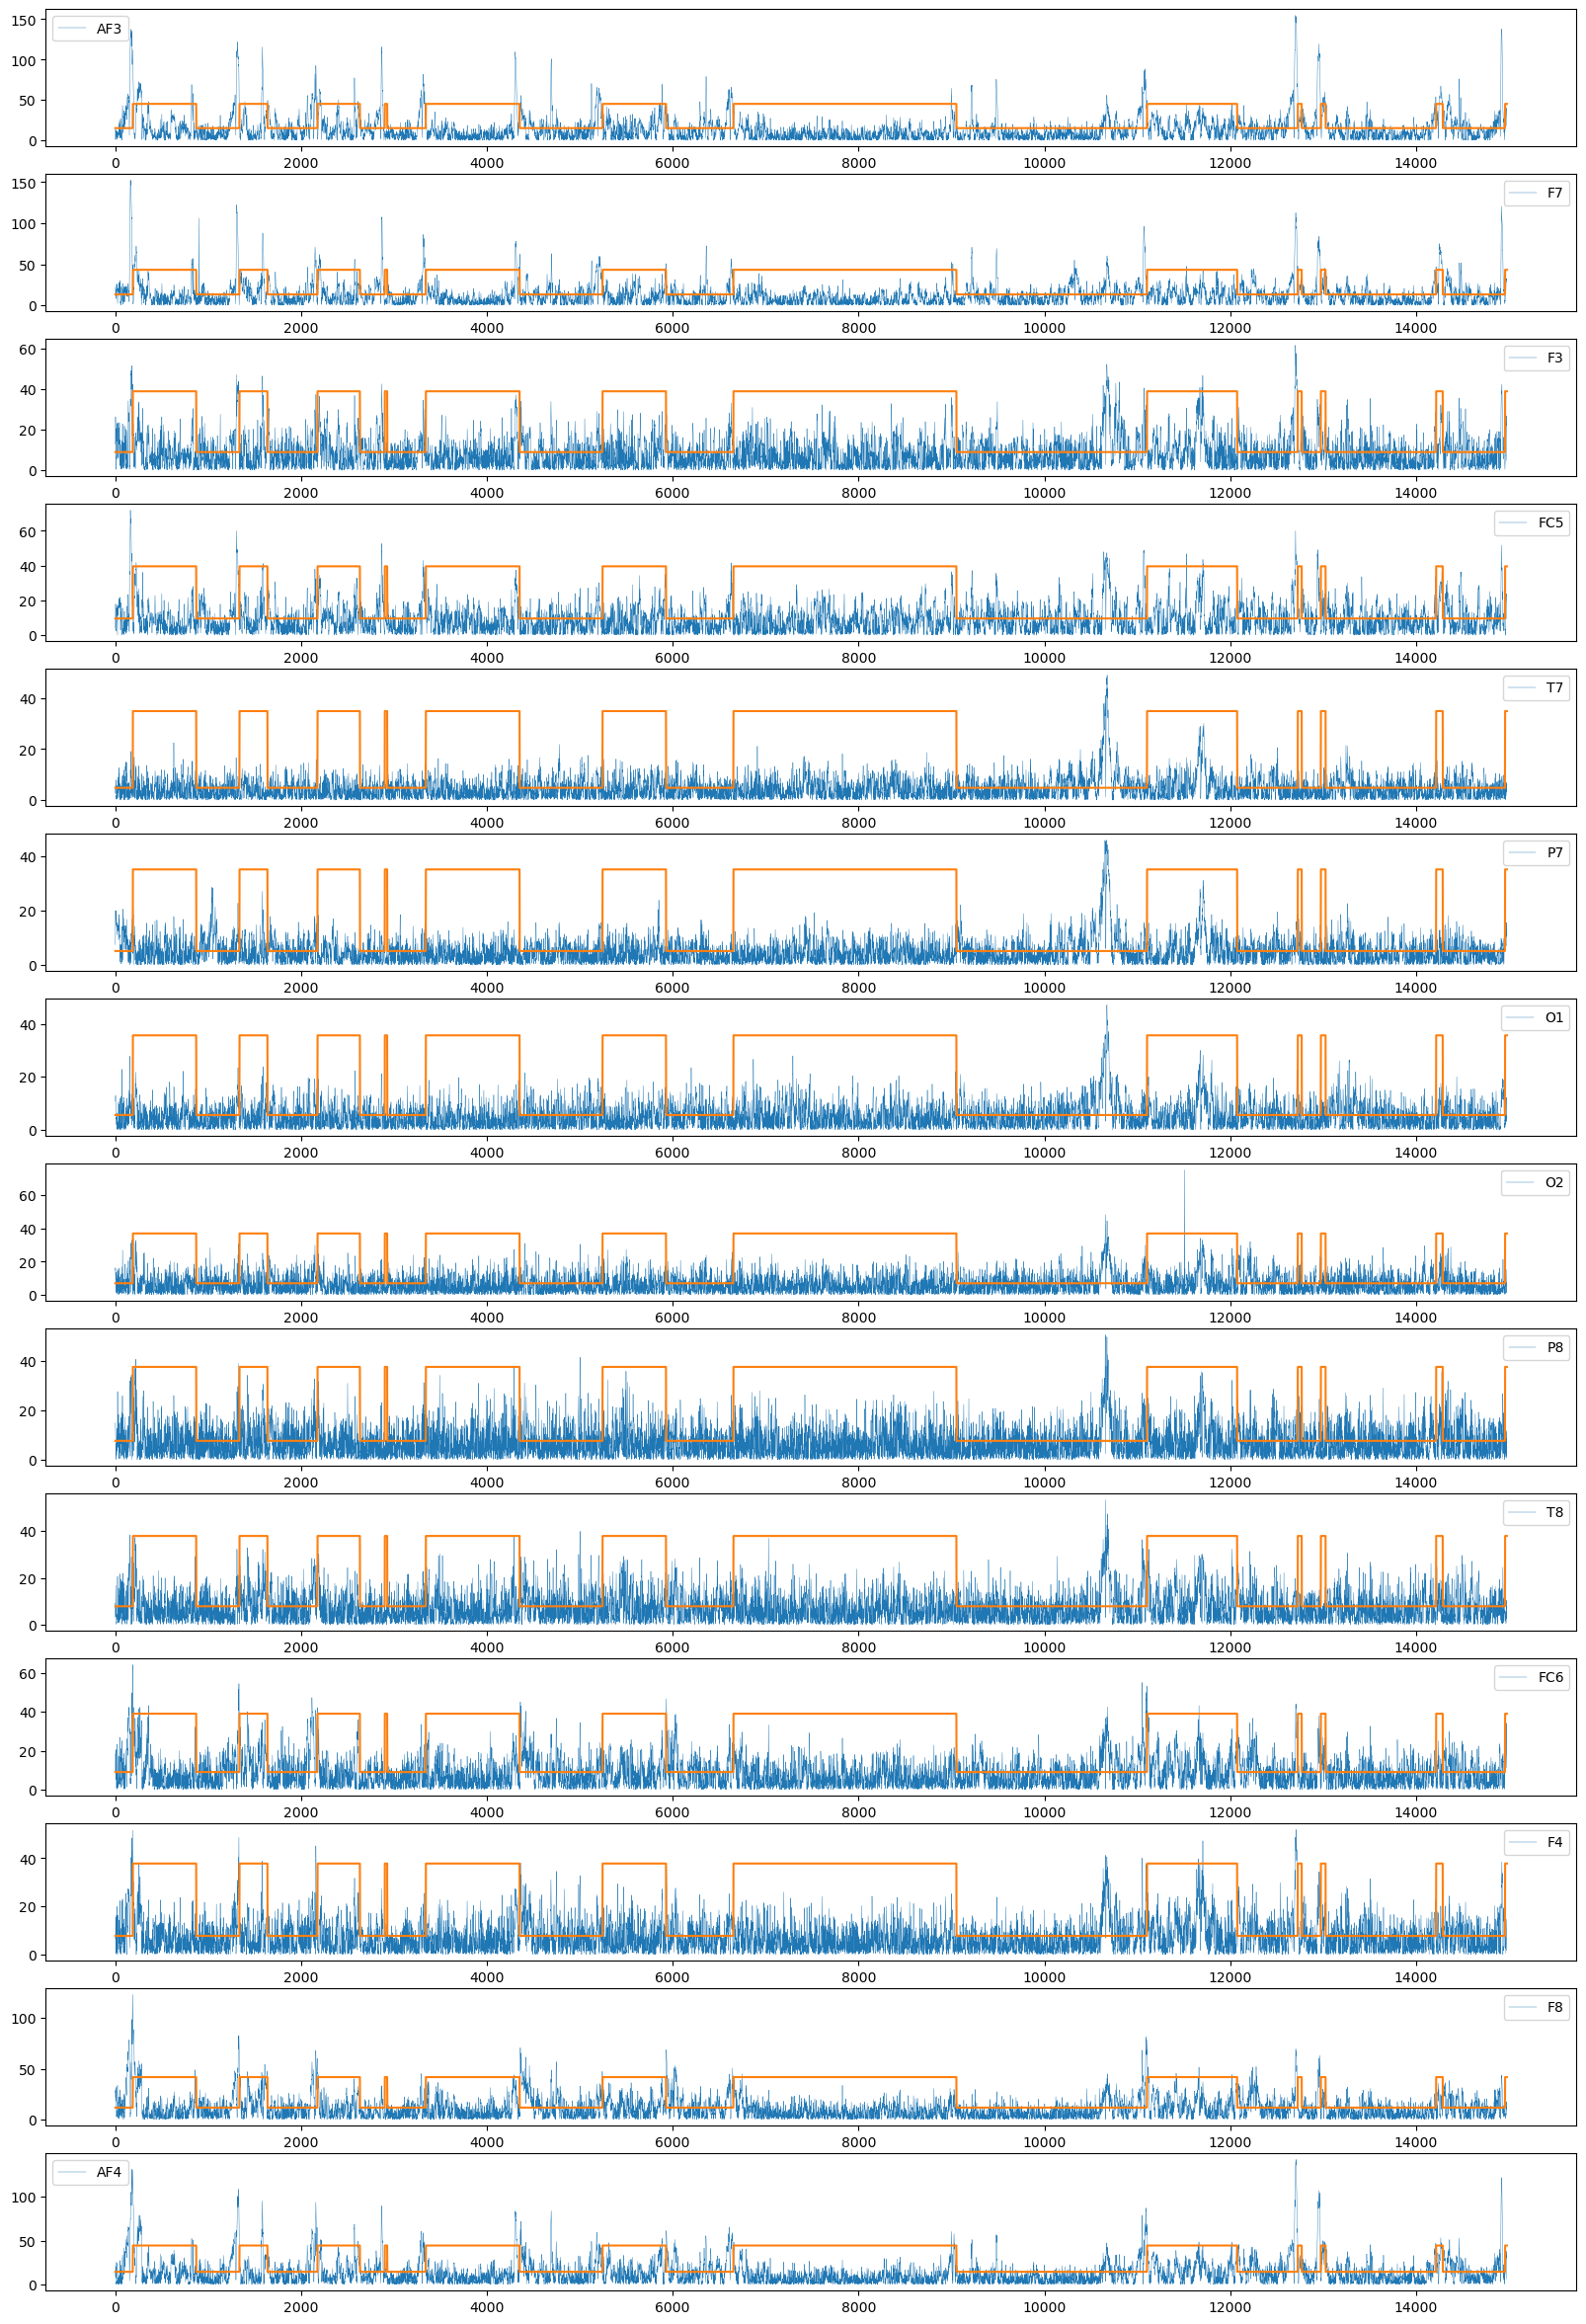

In [15]:
# subset of original data (.5-30 Hz) only containing entries
# where eyes are closed
EC = df[df.eyeDetection==1]

fig, axs = plt.subplots(14,1, figsize=(20,30))

for i in range(len(EC.columns)-1):
    col = df.columns[i]
    # same as prior cell, with the only
    # difference being df is used 
    # instead of abdf
    datafft = do_fft(df[col])
    noisefft = do_fft(EC[col])
    fluff_length = (len(datafft[0]) - len(noisefft[0]))/2
    fluff = np.zeros(int(fluff_length))

    noisefft = np.concatenate((fluff, noisefft[1], fluff))
    if len(datafft[1]) == len(noisefft):
        signalfft = datafft[1] - noisefft
    else:
        diff = len(noisefft) - len(datafft[1])
        signalfft = datafft[1] - noisefft[diff:]
    signal = do_ifft(signalfft)
    
    axs[i].plot(signal, label=col, linewidth=0.3)
    m = np.mean(signal)
    axs[i].plot(df.eyeDetection*30 + m)
    axs[i].legend()

## Method 3: Dividing Data By Noise
This has a similar idea from before, except now we are dividing by the noise, and converting to a ratio of signal/noise. 
1. $\tilde{s}(\omega) = \tilde{d}(\omega) - \tilde{\zeta}(\omega)$
1. $\frac{\tilde{s}(\omega)}{\tilde{\zeta}(\omega)} = \frac{\tilde{d}(\omega)}{\tilde{\zeta}(\omega)} - 1$

The idea is that the data is now scaled to be either significantly less than the noise (i.e. <1) or significantly greater than the noise (>1). This means that, after subtracting 1, any noise should be close to zero, meaning the only significant frequencies measured are those of the signal that have an amplitude greater than 0 or less than 0.

The same disclaimer as before also applies to this method for minimizing the noise. 

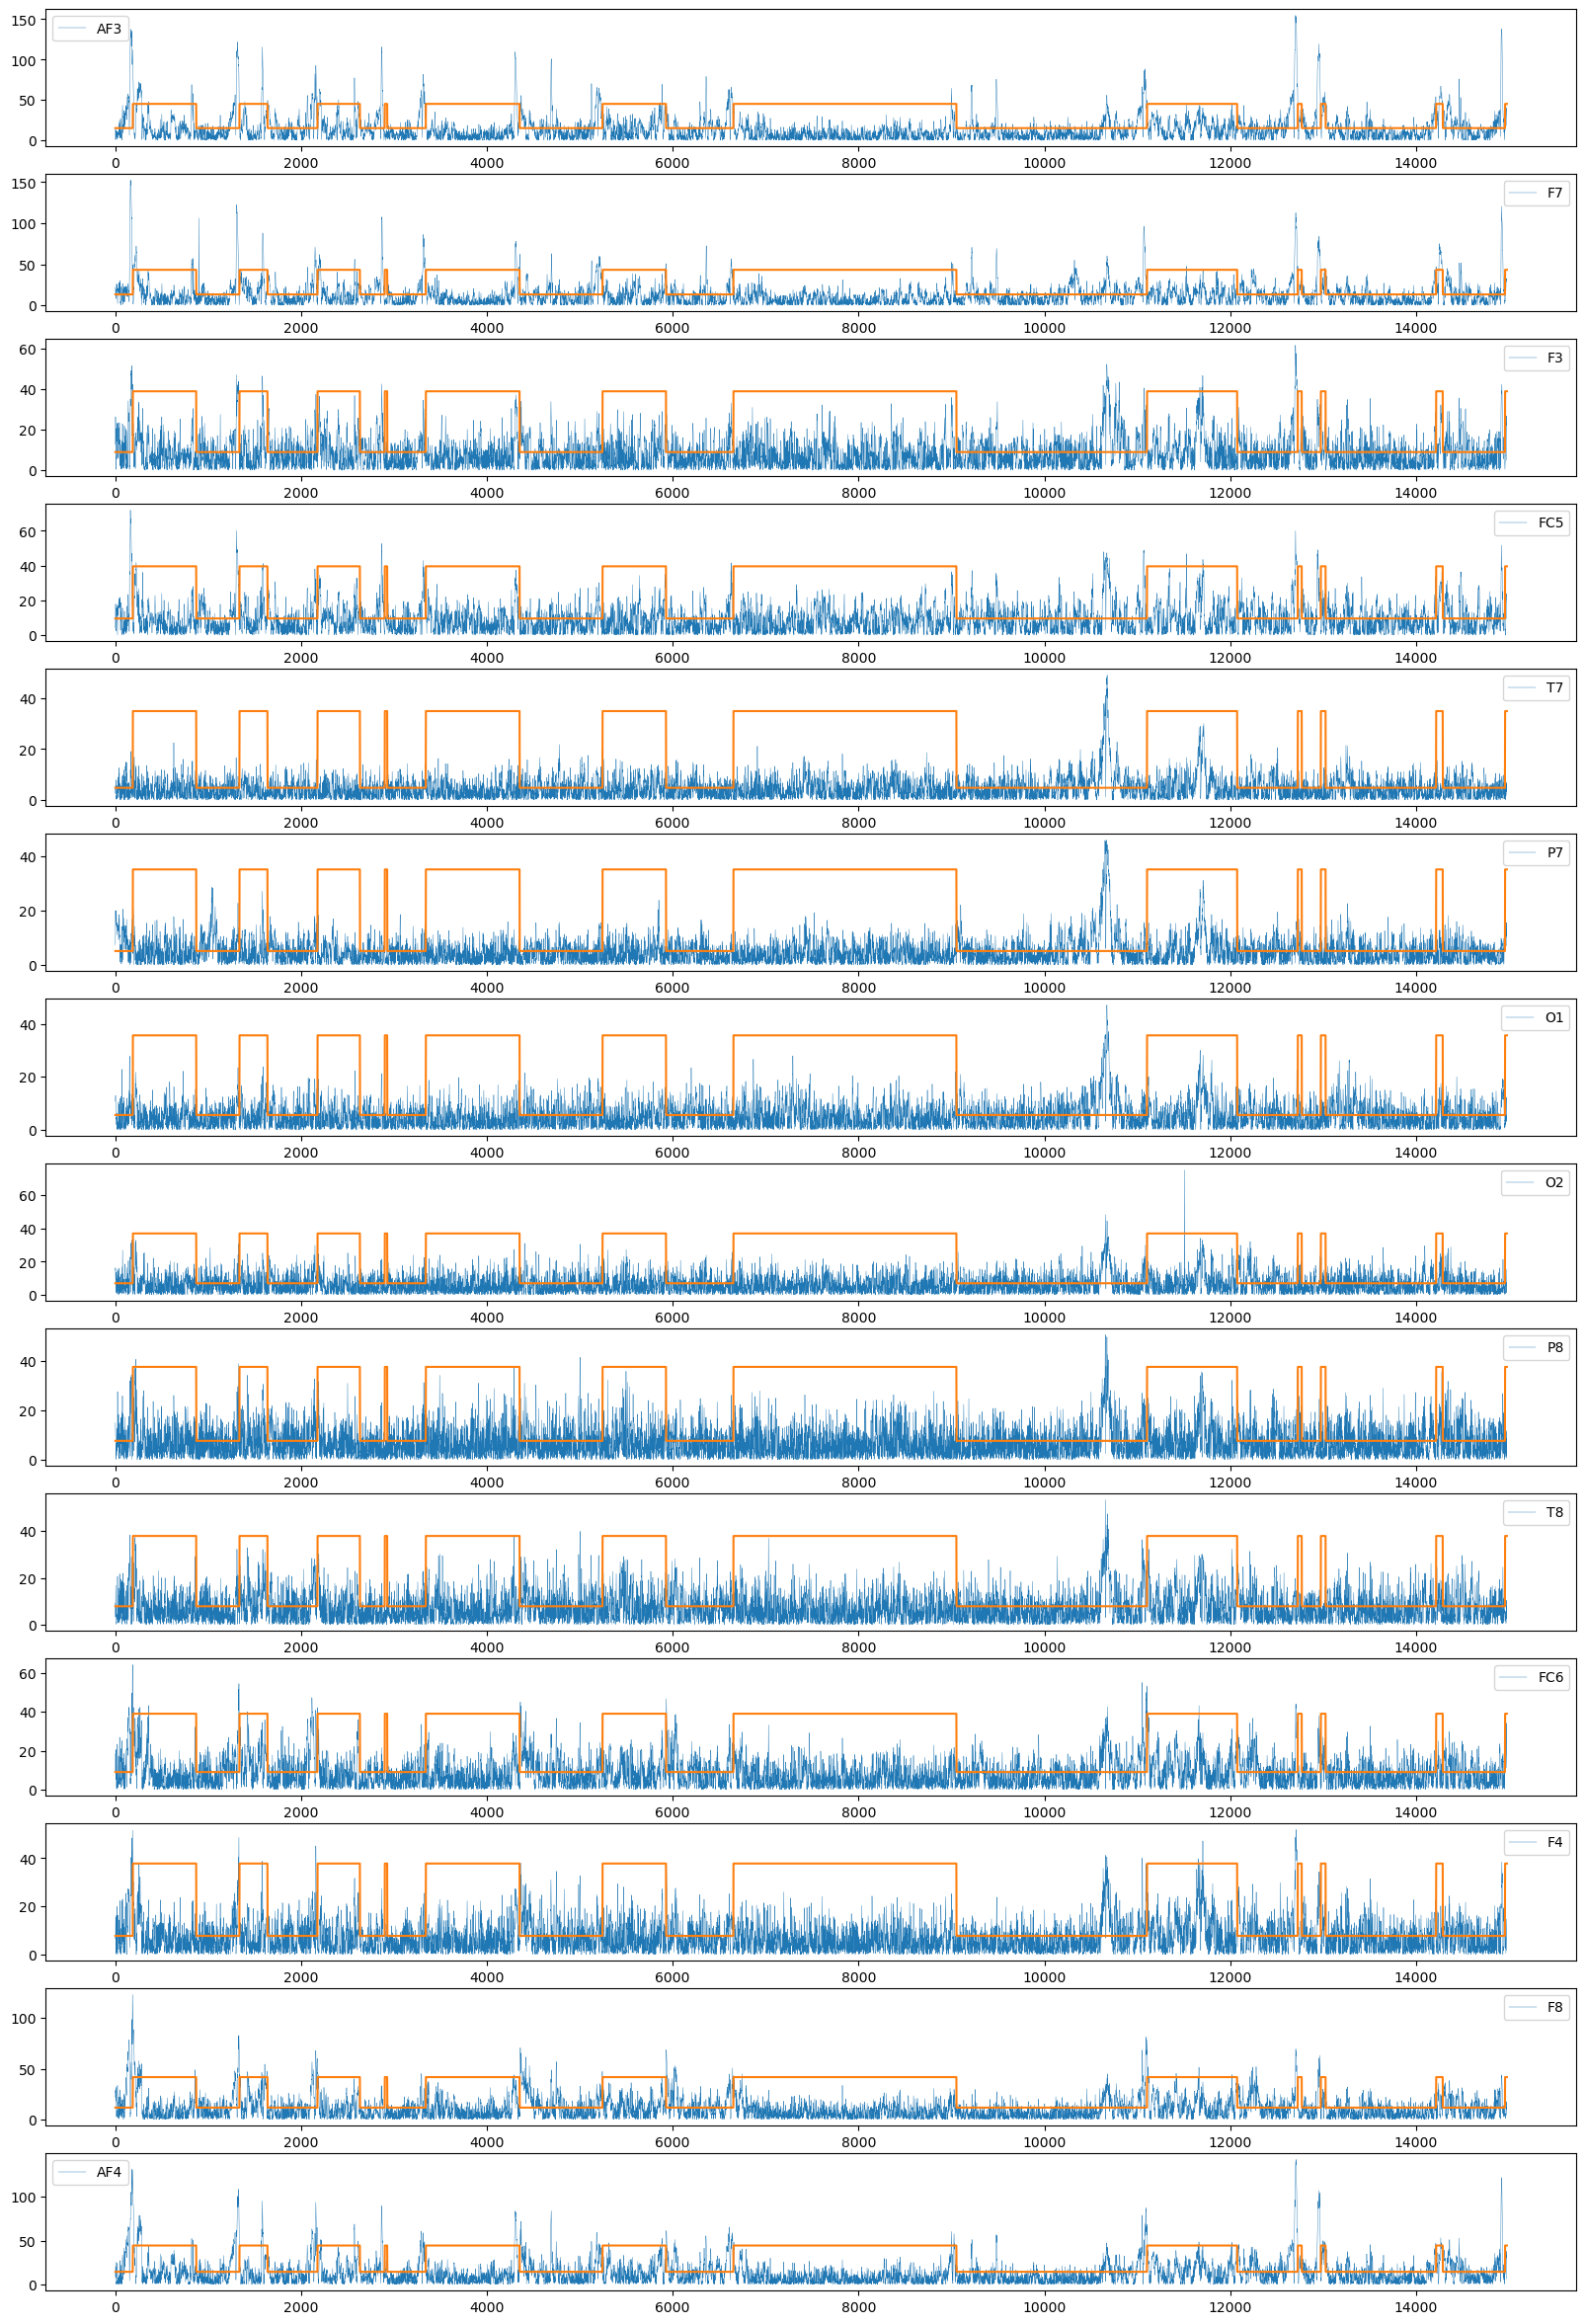

In [16]:
# subset of original data (.5-30 Hz) only containing entries
# where eyes are closed
EC = df[df.eyeDetection==1]

fig, axs = plt.subplots(14,1, figsize=(20,30))

# convert to frequency space, scale by noise and subtract all
# entries by 1, then plot in time space w/ eye open vs closed
for i in range(len(EC.columns)-1):
    # frequency space, fluff is now 1 since we are dividing
    # and not subtracting, and dividing by 1 will not effect
    # the data at that entry
    col = df.columns[i]
    datafft = do_fft(df[col])
    noisefft = do_fft(EC[col])
    fluff_length = (len(datafft[0]) - len(noisefft[0]))/2
    fluff = np.ones(int(fluff_length))
    
    # divide datafft by noisefft
    noisefft = np.concatenate((fluff, noisefft[1], fluff))
    if len(datafft[1]) == len(noisefft):
        signalfft = datafft[1] / noisefft
    else:
        diff = len(noisefft) - len(datafft[1])
        signalfft = datafft[1] / noisefft[diff:]
    # subtract each value by 1 and take the inverse
    signal = do_ifft(signalfft  - np.ones(len(signalfft)))
    
    # plot
    axs[i].plot(signal, label=col, linewidth=0.3)
    m = np.mean(signal)
    axs[i].plot(df.eyeDetection*30 + m)
    axs[i].legend()

### Results
The results appear to be similar to the previous method. Since this method involves more steps than the second method, it is more efficient to use the latter. 

## Conclusion
Given the three methods for minimizing noise in EEG data, it appears the most effective method is method two, as method three showed similar results but required more steps to do, and method one was ineffective at producing meaningful results. There are however some limitations to consider. For example, all analysis used the assumption that when eyes are closed there is only noise. It could be true that there is a signal (though different) produced when eyes are closed. There is then a possibility someone could assume the opposite, that there is only noise when eyes are open, and get similar results to this analysis. If there in fact is a signal when eyes are closed, that would render methods two and three invalid, as both rely on the eyes closed subset being only noise, and therefore time-independent. 

There are also some limitations of the data itself. Many people when doing research with EEG will record mutliple subjects doing the same task, and using an average of all their recordings to recover the signal. This would allow for any noise at each time step to be reduced to 0 or close to 0, as this is similar to doing $<d(t_n)> = <s(t_n)> + <\zeta(t_n)>$, with $<\zeta(t_n)> = 0$. Unfortunately, the dataset only has recordings for one person, so this was not an option.

There are also many unknowns about how the data was collected. For example, the creator only specified that the time period of the recording was 117 seconds, but does not give an exact measurement. This means that the time-step used throughout the analysis, 0.008s, could be false. It is also unclear where the recording took place, whether it was in a lab (where the noise from the environment is more controlled) or done at home (where there are many sources of noise the EEG could have sensed). 

Despite these limitations, this project was still successful in minimizing some noise within the data, at least for some channels. Similar methods for reducing noise can be applied to not only EEG data, but to other time series data. Any time series data that has labels for a given action/stimulus/event/etc. can use these methods for reducing noise and better visualizing the signal.